# Getting the Dataset

This example uses the Data Set 2(a) from the BCI Competition IV. After downloading and copying it into a directory called data next to this script, you should be able to follow this example.


# 1. Loading the Data 

In [1]:
import mne
%matplotlib inline
import numpy as np

# Mention the file path to the dataset
filename = "C:/Users/apple/Desktop/BCI4Kids/BCICIV_2a/A01T.gdf"

raw = mne.io.read_raw_gdf(filename)

print(raw.info)
print(raw.ch_names)

Extracting EDF parameters from C:\Users\apple\Desktop\BCI4Kids\BCICIV_2a\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
<Info | 7 non-empty values
 bads: []
 ch_names: EEG-Fz, EEG-0, EEG-1, EEG-2, EEG-3, EEG-4, EEG-5, EEG-C3, EEG-6, ...
 chs: 25 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 2005-01-17 12:00:00 UTC
 nchan: 25
 projs: []
 sfreq: 250.0 Hz
>
['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16', 'EOG-left', 'EOG-central', 'EOG-right']


C:\Users\apple\anaconda3\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


# 2. Events and Epoch Extraction

In [2]:
# Find the events time positions
events, _ = mne.events_from_annotations(raw)

# Pre-load the data
raw.load_data()

# Filter the raw signal with a band pass filter in 7-35 Hz
raw.filter(7., 35., fir_design='firwin')

# Remove the EOG channels and pick only desired EEG channels
raw.info['bads'] += ['EOG-left', 'EOG-central', 'EOG-right']
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False,
                       exclude='bads')

# Extracts epochs of 3s time period from the datset into 288 events for all 4 classes
tmin, tmax = 1., 4.

# left_hand = 769,right_hand = 770,foot = 771,tongue = 772
event_id = dict({'769': 7,'770': 8,'771': 9,'772': 10})

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 413 samples (1.652 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 751 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.9s finished


# 3. Epoch Average

<Evoked | '769' (average, N=72), 1 – 4 sec, baseline off, 22 ch, ~155 kB>


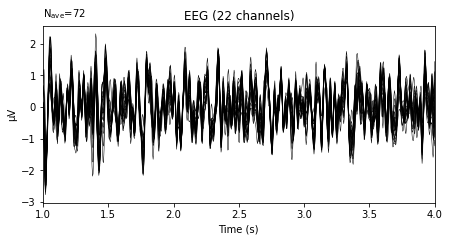

<Evoked | '770' (average, N=72), 1 – 4 sec, baseline off, 22 ch, ~155 kB>


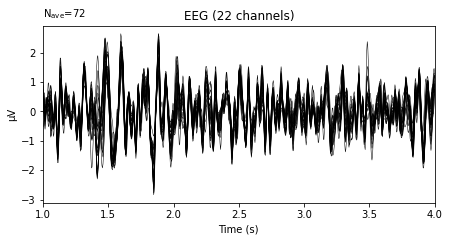

<Evoked | '771' (average, N=72), 1 – 4 sec, baseline off, 22 ch, ~155 kB>


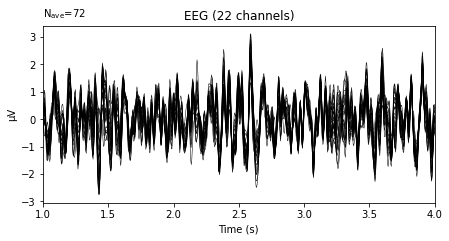

<Evoked | '772' (average, N=72), 1 – 4 sec, baseline off, 22 ch, ~155 kB>


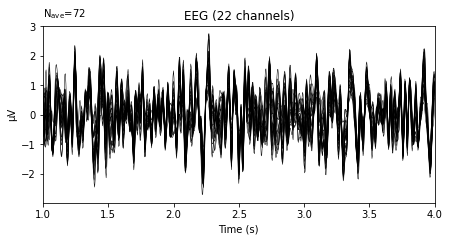

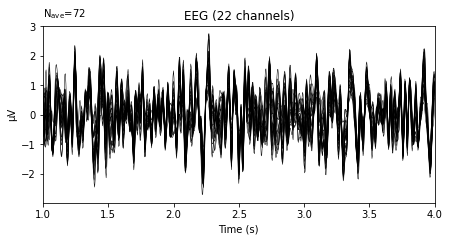

In [3]:
# left_hand = 769,right_hand = 770,foot = 771,tongue = 772

# Left hand epoch average plot
evoked = epochs['769'].average()
print(evoked)
evoked.plot(time_unit='s')

# Right hand epoch average plot
evoked = epochs['770'].average()
print(evoked)
evoked.plot(time_unit='s')

# Foot epoch average plot
evoked = epochs['771'].average()
print(evoked)
evoked.plot(time_unit='s')

# Tongue epoch average plot
evoked = epochs['772'].average()
print(evoked)
evoked.plot(time_unit='s')

# 4. Labels and Data

In [4]:
# Getting labels and changing labels from 7,8,9,10 -> 1,2,3,4
labels = epochs.events[:,-1] - 7 + 1 
data = epochs.get_data()

# 5. Wavelet Packet Decomposition

In [5]:
import pywt

# signal is decomposed to level 5 with 'db4' wavelet
def wpd(X): 
    coeffs = pywt.WaveletPacket(X,'db4',mode='symmetric',maxlevel=5)
    return coeffs
             
def feature_bands(x):
    Bands = np.empty((8,x.shape[0],x.shape[1],30)) # 8 freq band coefficients are chosen from the range 4-32Hz
    
    for i in range(x.shape[0]):
        for ii in range(x.shape[1]):
             pos = []
             C = wpd(x[i,ii,:]) 
             pos = np.append(pos,[node.path for node in C.get_level(5, 'natural')])
             for b in range(1,9):
                 Bands[b-1,i,ii,:] = C[pos[b]].data
    return Bands

wpd_data = feature_bands(data)

# 6. Common Spatial Pattern Filtering

In [6]:
from mne.decoding import CSP # Common Spatial Pattern Filtering
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from sklearn.model_selection import ShuffleSplit

# OneHotEncoding Labels
enc = OneHotEncoder()
X_out = enc.fit_transform(labels.reshape(-1,1)).toarray()

# Cross Validation Split
cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

acc = []
ka = []
prec = []
recall = []
f1_score = []

for train_idx, test_idx in cv.split(labels):
    
    Csp = [];ss = [] # empty lists
    
    label_train, label_test = labels[train_idx], labels[test_idx]
    y_train, y_test = X_out[train_idx], X_out[test_idx]
    
    # CSP filter applied separately for all Frequency band coefficients
    
    Csp = [CSP(n_components=4, reg=None, log=True, norm_trace=False) for _ in range(8)]
    ss = preprocessing.StandardScaler()

    X_train = ss.fit_transform(np.concatenate(tuple(Csp[x].fit_transform(wpd_data[x,train_idx,:,:],label_train) for x  in range(8)),axis=-1))

    X_test = ss.transform(np.concatenate(tuple(Csp[x].transform(wpd_data[x,test_idx,:,:]) for x  in range(8)),axis=-1))

Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 22 dim * 2.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)


Computing rank from data with rank=None
    Using tolerance 8.7e-07 (2.2e-16 eps * 22 dim * 1.8e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7e-07 (2.2e-16 eps * 22 dim * 1.4e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-07 (2.2e-16 eps * 22 dim * 1.7e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7e-07 (2.2e-16 eps * 22 dim * 1.4e+08  max singular value)
    

    Using tolerance 7e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.2e-06 (2.2e-16 eps * 22 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.8e-06 (2.2e-16 eps * 22 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank

    Using tolerance 9.3e-06 (2.2e-16 eps * 22 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.4e-06 (2.2e-16 eps * 22 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.6e-06 (2.2e-16 eps * 22 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9e-06 (2.2e-16 eps * 22 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: ra

    Using tolerance 6.3e-06 (2.2e-16 eps * 22 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.6e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.7e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.8e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: ra

    Using tolerance 6.1e-06 (2.2e-16 eps * 22 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.6e-06 (2.2e-16 eps * 22 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e-06 (2.2e-16 eps * 22 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e-06 (2.2e-16 eps * 22 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: ra

    Using tolerance 1.4e-05 (2.2e-16 eps * 22 dim * 2.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-05 (2.2e-16 eps * 22 dim * 3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 22 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-05 (2.2e-16 eps * 22 dim * 3.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank

    Using tolerance 9.8e-06 (2.2e-16 eps * 22 dim * 2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-05 (2.2e-16 eps * 22 dim * 2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 

    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 22 dim * 2.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 22 dim * 2.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22

    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-07 (2.2e-16 eps * 22 dim * 1.5e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.9e-07 (2.2e-16 eps * 22 dim * 1.6e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7e-07 (2.2e-16 eps * 22 dim * 1.4e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -

    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.1e-06 (2.2e-16 eps * 22 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-06 (2.2e-16 eps * 22 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.3e-06 (2.2e-16 eps * 22 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22

    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.4e-06 (2.2e-16 eps * 22 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9e-06 (2.2e-16 eps * 22 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.7e-06 (2.2e-16 eps * 22 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22

# 7. LDA Classifier Model 

In [7]:
pip install snakeviz

Note: you may need to restart the kernel to use updated packages.


In [8]:
import cProfile 
import cProfile as profile
import pstats
import scipy
from scipy import stats
from pstats import Stats
import sys

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import io
import csv

lda = LDA(n_components = 2)

X_train = lda.fit_transform(X_train, label_train)
X_test = lda.transform(X_test)

def LDA():

    from time import time
    start_time = time()
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import matthews_corrcoef
    from sklearn.metrics import f1_score
    
    # Fitting Logistic Regression to the Training set
    from sklearn.linear_model import LogisticRegression
    classifier = LogisticRegression(random_state = 0)
    classifier.fit(X_train, label_train)

    # Predicting the Test set results
    lda_predict = classifier.predict(X_test)

    # Making the Confusion Matrix
    cm = confusion_matrix(label_test, lda_predict)

    target_names = ['class 0', 'class 1', 'class 2', 'class 3']

    print('Accuracy Score:', accuracy_score(label_test, lda_predict))
    print('Confusion matrix \n',  confusion_matrix(label_test, lda_predict))
    print('Classification \n', classification_report(label_test, lda_predict, target_names=target_names ))
    
    lda_acc = accuracy_score(label_test, lda_predict)
    print('Accuracy: %f' % lda_acc)
    lda_ka = cohen_kappa_score(label_test, lda_predict)
    print('Cohen Kappa: %f' % lda_ka)
    lda_prec = precision_score(label_test, lda_predict, average='weighted')
    print('Precision: %f' % lda_prec)
    lda_rec = recall_score(label_test, lda_predict,average='weighted')
    print('Recall: %f' % lda_rec)
    lda_f1_score = f1_score(label_test, lda_predict, average='weighted')
    print('f1_score: %f' % lda_f1_score)
    
    #lda_acc = accuracy_score(label_test, lda_predict)

    # The Matthews correlation coefficient (MCC)
    
    lda_mcc= matthews_corrcoef(label_test,lda_predict)
    print(f'MCC: {round(lda_mcc,2)}')

    end_time = time()
    final_time = end_time-start_time

    print('final execution time is : {}'.format(final_time))   #Time in sec.
    
    
#Initialize profile class and call LDA() function
profiler = cProfile.Profile()
profiler.enable()
LDA()
profiler.disable()
stats = pstats.Stats(profiler).strip_dirs().sort_stats('cumtime')

# print stats to a string
result = io.StringIO()
pstats.Stats(profiler,stream=result).print_stats()
result=result.getvalue()

# chop the string into a csv-like buffer
result='ncalls'+result.split('ncalls')[-1]
result='\n'.join([','.join(line.rstrip().split(None,6)) for line in result.split('\n')])

# save it to disk
with open('LDA.csv', 'w+') as f:
    #f=open(result.rsplit('.')[0]+'.csv','w')
    f.write(result)
    f.close() 
    
    
%load_ext snakeviz
%snakeviz LDA()

Accuracy Score: 0.7586206896551724
Confusion matrix 
 [[11  1  0  0]
 [ 3 13  2  0]
 [ 1  0  6  3]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

     class 0       0.69      0.92      0.79        12
     class 1       0.93      0.72      0.81        18
     class 2       0.55      0.60      0.57        10
     class 3       0.82      0.78      0.80        18

    accuracy                           0.76        58
   macro avg       0.75      0.75      0.74        58
weighted avg       0.78      0.76      0.76        58

Accuracy: 0.758621
Cohen Kappa: 0.675719
Precision: 0.780041
Recall: 0.758621
f1_score: 0.761515
MCC: 0.68
final execution time is : 0.045851945877075195
Accuracy Score: 0.7586206896551724
Confusion matrix 
 [[11  1  0  0]
 [ 3 13  2  0]
 [ 1  0  6  3]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

     class 0       0.69      0.92      0.79        12
     class 1       0.93      0.72     

# To profile the 10 most time-consuming tasks of a LDA 

In [9]:
# print stats to a string
result = io.StringIO()
pstats.Stats(profiler,stream=result).print_stats()
result=result.getvalue()

profiler = cProfile.Profile()
profiler.enable()

LDA()

profiler.disable()
stats = Stats(profiler)
stats.sort_stats('tottime').print_stats(10)

%load_ext snakeviz
%snakeviz LDA()

Accuracy Score: 0.7586206896551724
Confusion matrix 
 [[11  1  0  0]
 [ 3 13  2  0]
 [ 1  0  6  3]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

     class 0       0.69      0.92      0.79        12
     class 1       0.93      0.72      0.81        18
     class 2       0.55      0.60      0.57        10
     class 3       0.82      0.78      0.80        18

    accuracy                           0.76        58
   macro avg       0.75      0.75      0.74        58
weighted avg       0.78      0.76      0.76        58

Accuracy: 0.758621
Cohen Kappa: 0.675719
Precision: 0.780041
Recall: 0.758621
f1_score: 0.761515
MCC: 0.68
final execution time is : 0.040986061096191406
         15280 function calls (15181 primitive calls) in 0.042 seconds

   Ordered by: internal time
   List reduced from 470 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      184    0.003    0.000    0.003    0.000 {met

# 1. LDA

In [10]:
from time import time
start_time = time()
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
    
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, label_train)

# Predicting the Test set results
lda_predict = classifier.predict(X_test)

# Making the Confusion Matrix
cm = confusion_matrix(label_test, lda_predict)

target_names = ['class 0', 'class 1', 'class 2', 'class 3']

print('Accuracy Score:', accuracy_score(label_test, lda_predict))
print('Confusion matrix \n',  confusion_matrix(label_test, lda_predict))
print('Classification \n', classification_report(label_test, lda_predict, target_names=target_names ))
    
lda_acc = accuracy_score(label_test, lda_predict)
print('Accuracy: %f' % lda_acc)
lda_ka = cohen_kappa_score(label_test, lda_predict)
print('Cohen Kappa: %f' % lda_ka)
lda_prec = precision_score(label_test, lda_predict, average='weighted')
print('Precision: %f' % lda_prec)
lda_rec = recall_score(label_test, lda_predict,average='weighted')
print('Recall: %f' % lda_rec)
lda_f1_score = f1_score(label_test, lda_predict, average='weighted')
print('f1_score: %f' % lda_f1_score)

# The Matthews correlation coefficient (MCC)
    
lda_mcc= matthews_corrcoef(label_test,lda_predict)
print(f'MCC: {round(lda_mcc,2)}')

end_time = time()
final_time = end_time-start_time

print('final execution time is : {}'.format(final_time))   #Time in sec.
    

Accuracy Score: 0.7586206896551724
Confusion matrix 
 [[11  1  0  0]
 [ 3 13  2  0]
 [ 1  0  6  3]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

     class 0       0.69      0.92      0.79        12
     class 1       0.93      0.72      0.81        18
     class 2       0.55      0.60      0.57        10
     class 3       0.82      0.78      0.80        18

    accuracy                           0.76        58
   macro avg       0.75      0.75      0.74        58
weighted avg       0.78      0.76      0.76        58

Accuracy: 0.758621
Cohen Kappa: 0.675719
Precision: 0.780041
Recall: 0.758621
f1_score: 0.761515
MCC: 0.68
final execution time is : 0.034998178482055664


# 8. KNN Classifier Model

In [11]:
from sklearn.neighbors import KNeighborsClassifier
import cProfile 
import cProfile as profile
import pstats
import scipy
from scipy import stats
from pstats import Stats
import sys

import io
import csv



def KNN():

    from time import time
    start_time = time()
    from sklearn import neighbors, datasets, preprocessing
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import matthews_corrcoef
    from sklearn import metrics
    from sklearn.metrics import f1_score

    # Modeling KNN classifiers.
    knn = neighbors.KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, label_train)
    kn_predict = knn.predict(X_test)

    # Display the Output
    print('Accuracy Score:', accuracy_score(label_test, kn_predict))
    print('Confusion matrix \n',  confusion_matrix(label_test, kn_predict))
    print('Classification \n', classification_report(label_test, kn_predict))
    
    knn_acc = accuracy_score(label_test, kn_predict)
    print('Accuracy: %f' % knn_acc)
    knn_ka = cohen_kappa_score(label_test, kn_predict)
    print('Cohen Kappa: %f' % knn_ka)
    knn_prec = precision_score(label_test, kn_predict, average='weighted')
    print('Precision: %f' % knn_prec)
    knn_rec = recall_score(label_test, kn_predict, average='weighted')
    print('Recall: %f' % knn_rec)
    knn_f1_score = f1_score(label_test, kn_predict, average='weighted')
    print('f1_score: %f' % knn_f1_score)
    
    # The Matthews correlation coefficient (MCC)
    knn_mcc= matthews_corrcoef(label_test,kn_predict)
    print(f'MCC: {round(knn_mcc,2)}')

    end_time = time()
    final_time = end_time-start_time

    print('final execution time is : {}'.format(final_time))
    
#Initialize profile class and call KNN() function
profiler = cProfile.Profile()
profiler.enable()
KNN()
profiler.disable()
stats = pstats.Stats(profiler).strip_dirs().sort_stats('cumtime')


#Print the stats report
stats.print_stats()

# print stats to a string
result = io.StringIO()
pstats.Stats(profiler,stream=result).print_stats()
result=result.getvalue()

# chop the string into a csv-like buffer
result='ncalls'+result.split('ncalls')[-1]
result='\n'.join([','.join(line.rstrip().split(None,6)) for line in result.split('\n')])

# save it to disk
with open('KNN.csv', 'w+') as f:
    #f=open(result.rsplit('.')[0]+'.csv','w')
    f.write(result)
    f.close() 

%load_ext snakeviz
%snakeviz KNN()

Accuracy Score: 0.7241379310344828
Confusion matrix 
 [[ 9  3  0  0]
 [ 3 14  1  0]
 [ 1  0  5  4]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

           1       0.64      0.75      0.69        12
           2       0.82      0.78      0.80        18
           3       0.56      0.50      0.53        10
           4       0.78      0.78      0.78        18

    accuracy                           0.72        58
   macro avg       0.70      0.70      0.70        58
weighted avg       0.73      0.72      0.72        58

Accuracy: 0.724138
Cohen Kappa: 0.625202
Precision: 0.725748
Recall: 0.724138
f1_score: 0.723635
MCC: 0.63
final execution time is : 0.49448108673095703
         52641 function calls (51404 primitive calls) in 0.495 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        5    0.000    0.000    0.657    0.131 __init__.py:1(<module>)
        2    0.000    0.000    0.4

       59    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:152(__init__)
      182    0.000    0.000    0.000    0.000 {method '__exit__' of '_thread.lock' objects}
        1    0.000    0.000    0.000    0.000 parallel.py:385(effective_n_jobs)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        1    0.000    0.000    0.000    0.000 enum.py:164(__prepare__)
        1    0.000    0.000    0.000    0.000 arrayprint.py:410(<lambda>)
       86    0.000    0.000    0.000    0.000 _base.py:1294(isspmatrix)
       47    0.000    0.000    0.000    0.000 fromnumeric.py:70(<dictcomp>)
       58    0.000    0.000    0.000    0.000 {built-in method _imp.is_frozen}
       41    0.000    0.000    0.000    0.000 {method 'extend' of 'list' objects}
       15    0.000    0.000    0.000    0.000 typing.py:463(<genexpr>)
        1    0.000    0.000    0.000    0.000 arrayprint.py:1223(__init__)
        2    0.000    0.000    0.000    0.000 _base.py:81

        1    0.000    0.000    0.000    0.000 hb.py:382(<listcomp>)
        1    0.000    0.000    0.000    0.000 queue.py:206(_init)
        6    0.000    0.000    0.000    0.000 fromnumeric.py:2399(_all_dispatcher)
        1    0.000    0.000    0.000    0.000 _arffread.py:255(DateAttribute)
        5    0.000    0.000    0.000    0.000 {method '__exit__' of '_thread.RLock' objects}
        2    0.000    0.000    0.000    0.000 ipstruct.py:125(__getattr__)
        3    0.000    0.000    0.000    0.000 fromnumeric.py:3164(ndim)
        3    0.000    0.000    0.000    0.000 _data.py:23(_get_dtype)
        1    0.000    0.000    0.000    0.000 _mio4.py:84(VarHeader4)
        1    0.000    0.000    0.000    0.000 _fortran_format_parser.py:221(FortranFormatParser)
        1    0.000    0.000    0.000    0.000 {method 'take' of 'numpy.ndarray' objects}
        3    0.000    0.000    0.000    0.000 enum.py:244(<genexpr>)
        1    0.000    0.000    0.000    0.000 _arff.py:901(ArffEncoder

# To profile the 10 most time-consuming tasks of a KNN

In [12]:
# print stats to a string
result = io.StringIO()
pstats.Stats(profiler,stream=result).print_stats()
result=result.getvalue()

profiler = cProfile.Profile()
profiler.enable()

KNN()

profiler.disable()
stats = Stats(profiler)
stats.sort_stats('tottime').print_stats(10)

%load_ext snakeviz
%snakeviz KNN()

Accuracy Score: 0.7241379310344828
Confusion matrix 
 [[ 9  3  0  0]
 [ 3 14  1  0]
 [ 1  0  5  4]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

           1       0.64      0.75      0.69        12
           2       0.82      0.78      0.80        18
           3       0.56      0.50      0.53        10
           4       0.78      0.78      0.78        18

    accuracy                           0.72        58
   macro avg       0.70      0.70      0.70        58
weighted avg       0.73      0.72      0.72        58

Accuracy: 0.724138
Cohen Kappa: 0.625202
Precision: 0.725748
Recall: 0.724138
f1_score: 0.723635
MCC: 0.63
final execution time is : 0.029000520706176758
         13810 function calls (13536 primitive calls) in 0.029 seconds

   Ordered by: internal time
   List reduced from 453 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      233    0.005    0.000    0.010    0.000 C:\U

# 2. KNN 

In [13]:
from time import time
start_time = time()
from sklearn import neighbors, datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
from sklearn.metrics import f1_score

# Modeling KNN classifiers.
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, label_train)
kn_predict = knn.predict(X_test)

# Display the Output
print('Accuracy Score:', accuracy_score(label_test, kn_predict))
print('Confusion matrix \n',  confusion_matrix(label_test, kn_predict))
print('Classification \n', classification_report(label_test, kn_predict))
    
knn_acc = accuracy_score(label_test, kn_predict)
print('Accuracy: %f' % knn_acc)
knn_ka = cohen_kappa_score(label_test, kn_predict)
print('Cohen Kappa: %f' % knn_ka)
knn_prec = precision_score(label_test, kn_predict, average='weighted')
print('Precision: %f' % knn_prec)
knn_rec = recall_score(label_test, kn_predict, average='weighted')
print('Recall: %f' % knn_rec)
knn_f1_score = f1_score(label_test, kn_predict, average='weighted')
print('f1_score: %f' % knn_f1_score)
    
# The Matthews correlation coefficient (MCC)
knn_mcc= matthews_corrcoef(label_test,kn_predict)
print(f'MCC: {round(knn_mcc,2)}')

end_time = time()
final_time = end_time-start_time

print('final execution time is : {}'.format(final_time))

Accuracy Score: 0.7241379310344828
Confusion matrix 
 [[ 9  3  0  0]
 [ 3 14  1  0]
 [ 1  0  5  4]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

           1       0.64      0.75      0.69        12
           2       0.82      0.78      0.80        18
           3       0.56      0.50      0.53        10
           4       0.78      0.78      0.78        18

    accuracy                           0.72        58
   macro avg       0.70      0.70      0.70        58
weighted avg       0.73      0.72      0.72        58

Accuracy: 0.724138
Cohen Kappa: 0.625202
Precision: 0.725748
Recall: 0.724138
f1_score: 0.723635
MCC: 0.63
final execution time is : 0.03200793266296387


# 9. SVM Classifier Model

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import cProfile 
import cProfile as profile
import pstats
import scipy
from scipy import stats
from pstats import Stats
import sys

import io
import csv

def SVM():

    from time import time
    start_time = time()
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import matthews_corrcoef
    from sklearn import metrics
    from sklearn.metrics import f1_score
    
    # Modeling SVM classifiers.
    svm = SVC()
    svm.fit(X_train, label_train)
    svm_predict= svm.predict(X_test)

    print('Accuracy Score:', accuracy_score(label_test, svm_predict))
    print('Confusion matrix \n',  confusion_matrix(label_test, svm_predict))
    print('Classification \n', classification_report(label_test, svm_predict))
    
    svm_acc = accuracy_score(label_test, svm_predict)
    print('Accuracy: %f' % svm_acc)
    svm_ka = cohen_kappa_score(label_test, svm_predict)
    print('Cohen Kappa: %f' % svm_ka)
    svm_prec = precision_score(label_test, svm_predict, average='weighted')
    print('Precision: %f' % svm_prec)
    svm_rec = recall_score(label_test, svm_predict, average='weighted')
    print('Recall: %f' % svm_rec)
    svm_f1_score = f1_score(label_test, svm_predict, average='weighted')
    print('f1_score: %f' % svm_f1_score)

    # from sklearn.metrics import matthews_corrcoef
    svm_mcc= matthews_corrcoef(label_test,svm_predict)
    print(f'MCC: {round(svm_mcc,2)}')

    end_time = time()
    final_time = end_time-start_time

    print('final execution time is : {}'.format(final_time))


#Initialize profile class and call LDA() function
profiler = cProfile.Profile()
profiler.enable()
SVM()
profiler.disable()
stats = pstats.Stats(profiler).strip_dirs().sort_stats('cumtime')

#Print the stats report
stats.print_stats()

# print stats to a string
result = io.StringIO()
pstats.Stats(profiler,stream=result).print_stats()
result=result.getvalue()

# chop the string into a csv-like buffer
result='ncalls'+result.split('ncalls')[-1]
result='\n'.join([','.join(line.rstrip().split(None,6)) for line in result.split('\n')])

# save it to disk
with open('SVM.csv', 'w+') as f:
    #f=open(result.rsplit('.')[0]+'.csv','w')
    f.write(result)
    f.close() 

%load_ext snakeviz
%snakeviz SVM()

Accuracy Score: 0.7586206896551724
Confusion matrix 
 [[10  1  1  0]
 [ 3 14  1  0]
 [ 1  0  6  3]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

           1       0.67      0.83      0.74        12
           2       0.93      0.78      0.85        18
           3       0.55      0.60      0.57        10
           4       0.82      0.78      0.80        18

    accuracy                           0.76        58
   macro avg       0.74      0.75      0.74        58
weighted avg       0.78      0.76      0.76        58

Accuracy: 0.758621
Cohen Kappa: 0.674940
Precision: 0.777208
Recall: 0.758621
f1_score: 0.763378
MCC: 0.68
final execution time is : 0.02313828468322754
         11315 function calls (11220 primitive calls) in 0.024 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.023    0.012 interactiveshell.py:3403(run_code)
        2    0.000    0

       20    0.000    0.000    0.000    0.000 arraysetops.py:515(_in1d_dispatcher)
        3    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
        3    0.000    0.000    0.000    0.000 validation.py:571(_check_estimator_name)
        2    0.000    0.000    0.000    0.000 hooks.py:103(__call__)
       21    0.000    0.000    0.000    0.000 multiarray.py:883(bincount)
        7    0.000    0.000    0.000    0.000 {method 'tolist' of 'numpy.ndarray' objects}
       10    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.normalize_axis_index}
        2    0.000    0.000    0.000    0.000 traitlets.py:566(__get__)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.locals}
       18    0.000    0.000    0.000    0.000 _base.py:119(get_shape)
        2    0.000    0.000    0.000    0.000 validation.py:1824(_get_feature_names)
        1    0.000    0.000    0.000    0.000 131858220.py:60(<module>)
        4    0.000    0.000

# To profile the 10 most time-consuming tasks of a SVM

In [15]:
# print stats to a string
result = io.StringIO()
pstats.Stats(profiler,stream=result).print_stats()
result=result.getvalue()

profiler = cProfile.Profile()
profiler.enable()

SVM()

profiler.disable()
stats = Stats(profiler)
stats.sort_stats('tottime').print_stats(10)

%load_ext snakeviz
%snakeviz SVM()

Accuracy Score: 0.7586206896551724
Confusion matrix 
 [[10  1  1  0]
 [ 3 14  1  0]
 [ 1  0  6  3]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

           1       0.67      0.83      0.74        12
           2       0.93      0.78      0.85        18
           3       0.55      0.60      0.57        10
           4       0.82      0.78      0.80        18

    accuracy                           0.76        58
   macro avg       0.74      0.75      0.74        58
weighted avg       0.78      0.76      0.76        58

Accuracy: 0.758621
Cohen Kappa: 0.674940
Precision: 0.777208
Recall: 0.758621
f1_score: 0.763378
MCC: 0.68
final execution time is : 0.028990745544433594
         11315 function calls (11220 primitive calls) in 0.029 seconds

   Ordered by: internal time
   List reduced from 322 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.003    0.003    0.003    0.003 {skl

# 3. SVM

In [16]:
from time import time
start_time = time()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
from sklearn.metrics import f1_score
    
# Modeling SVM classifiers.
svm = SVC()
svm.fit(X_train, label_train)
svm_predict= svm.predict(X_test)

print('Accuracy Score:', accuracy_score(label_test, svm_predict))
print('Confusion matrix \n',  confusion_matrix(label_test, svm_predict))
print('Classification \n', classification_report(label_test, svm_predict))
    
svm_acc = accuracy_score(label_test, svm_predict)
print('Accuracy: %f' % svm_acc)
svm_ka = cohen_kappa_score(label_test, svm_predict)
print('Cohen Kappa: %f' % svm_ka)
svm_prec = precision_score(label_test, svm_predict, average='weighted')
print('Precision: %f' % svm_prec)
svm_rec = recall_score(label_test, svm_predict, average='weighted')
print('Recall: %f' % svm_rec)
svm_f1_score = f1_score(label_test, svm_predict, average='weighted')
print('f1_score: %f' % svm_f1_score)

# from sklearn.metrics import matthews_corrcoef
svm_mcc= matthews_corrcoef(label_test,svm_predict)
print(f'MCC: {round(svm_mcc,2)}')

end_time = time()
final_time = end_time-start_time

print('final execution time is : {}'.format(final_time))

Accuracy Score: 0.7586206896551724
Confusion matrix 
 [[10  1  1  0]
 [ 3 14  1  0]
 [ 1  0  6  3]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

           1       0.67      0.83      0.74        12
           2       0.93      0.78      0.85        18
           3       0.55      0.60      0.57        10
           4       0.82      0.78      0.80        18

    accuracy                           0.76        58
   macro avg       0.74      0.75      0.74        58
weighted avg       0.78      0.76      0.76        58

Accuracy: 0.758621
Cohen Kappa: 0.674940
Precision: 0.777208
Recall: 0.758621
f1_score: 0.763378
MCC: 0.68
final execution time is : 0.034722089767456055


# 10. Random Forest Classifier Model

In [17]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import cProfile 
import cProfile as profile
import pstats
import scipy
from scipy import stats
from pstats import Stats
import sys

import io
import csv

def RF():

    from time import time
    start_time = time()
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import matthews_corrcoef
    from sklearn import metrics
    from sklearn.metrics import f1_score
    
    # Modeling RF classifiers.
    rf_classifier = RandomForestClassifier(n_estimators=100)
    rf_classifier.fit(X_train,label_train)
    rf_predict= rf_classifier.predict(X_test)

    # Making the Confusion Matrix
    cm = confusion_matrix(label_test, rf_predict)

    print('Accuracy Score:', accuracy_score(label_test, rf_predict))
    print('Confusion matrix \n',  confusion_matrix(label_test, rf_predict))
    print('Classification \n', classification_report(label_test, rf_predict))
    
    rf_acc = accuracy_score(label_test, rf_predict)
    print('Accuracy: %f' % rf_acc)
    rf_ka = cohen_kappa_score(label_test, rf_predict)
    print('Cohen Kappa: %f' % rf_ka)
    rf_prec = precision_score(label_test, rf_predict, average='weighted')
    print('Precision: %f' % rf_prec)
    rf_rec = recall_score(label_test, rf_predict, average='weighted')
    print('Recall: %f' % rf_rec)
    rf_f1_score = f1_score(label_test, rf_predict, average='weighted')
    print('f1_score: %f' % rf_f1_score)
  
    # from sklearn.metrics import matthews_corrcoef
    rf_mcc= matthews_corrcoef(label_test,rf_predict)

    print(f'MCC: {round(rf_mcc,2)}')

    end_time = time()
    final_time = end_time-start_time

    print('final execution time is : {}'.format(final_time))

#Initialize profile class and call KNN() function
profiler = cProfile.Profile()
profiler.enable()
RF()
profiler.disable()
stats = pstats.Stats(profiler).strip_dirs().sort_stats('cumtime')


#Print the stats report
stats.print_stats()
    

%load_ext snakeviz
%snakeviz RF()

Accuracy Score: 0.7413793103448276
Confusion matrix 
 [[11  1  0  0]
 [ 3 13  2  0]
 [ 1  0  5  4]
 [ 0  0  4 14]]
Classification 
               precision    recall  f1-score   support

           1       0.73      0.92      0.81        12
           2       0.93      0.72      0.81        18
           3       0.45      0.50      0.48        10
           4       0.78      0.78      0.78        18

    accuracy                           0.74        58
   macro avg       0.72      0.73      0.72        58
weighted avg       0.76      0.74      0.74        58

Accuracy: 0.741379
Cohen Kappa: 0.651721
Precision: 0.759651
Recall: 0.741379
f1_score: 0.744219
MCC: 0.66
final execution time is : 0.2560265064239502
         210135 function calls (208736 primitive calls) in 0.256 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.256    0.128 interactiveshell.py:3403(run_code)
        2    0.000    

        4    0.000    0.000    0.000    0.000 type_check.py:404(nan_to_num)
        8    0.000    0.000    0.000    0.000 _base.py:291(nnz)
       68    0.000    0.000    0.000    0.000 fromnumeric.py:1965(shape)
      100    0.000    0.000    0.000    0.000 {built-in method _operator.gt}
      100    0.000    0.000    0.000    0.000 fromnumeric.py:2965(_prod_dispatcher)
        4    0.000    0.000    0.000    0.000 _sputils.py:220(isshape)
       16    0.000    0.000    0.000    0.000 arrayprint.py:739(_extendLine)
      102    0.000    0.000    0.000    0.000 fromnumeric.py:2491(_cumsum_dispatcher)
       26    0.000    0.000    0.000    0.000 iostream.py:437(_schedule_flush)
      101    0.000    0.000    0.000    0.000 function_base.py:842(_copy_dispatcher)
      101    0.000    0.000    0.000    0.000 fromnumeric.py:2670(_amax_dispatcher)
        6    0.000    0.000    0.000    0.000 threading.py:228(__init__)
        2    0.000    0.000    0.000    0.000 uuid.py:138(__init__)
   

Accuracy Score: 0.7758620689655172
Confusion matrix 
 [[10  2  0  0]
 [ 2 14  2  0]
 [ 1  0  6  3]
 [ 0  0  3 15]]
Classification 
               precision    recall  f1-score   support

           1       0.77      0.83      0.80        12
           2       0.88      0.78      0.82        18
           3       0.55      0.60      0.57        10
           4       0.83      0.83      0.83        18

    accuracy                           0.78        58
   macro avg       0.76      0.76      0.76        58
weighted avg       0.78      0.78      0.78        58

Accuracy: 0.775862
Cohen Kappa: 0.696702
Precision: 0.783367
Recall: 0.775862
f1_score: 0.778238
MCC: 0.7
final execution time is : 0.33966755867004395
 
*** Profile stats marshalled to file 'C:\\Users\\apple\\AppData\\Local\\Temp\\tmpkxsigati'. 
Embedding SnakeViz in this document...


# To profile the 10 most time-consuming tasks of a Random Forest

In [18]:
# print stats to a string
result = io.StringIO()
pstats.Stats(profiler,stream=result).print_stats()
result=result.getvalue()

profiler = cProfile.Profile()
profiler.enable()

RF()

profiler.disable()
stats = Stats(profiler)
stats.sort_stats('tottime').print_stats(10)

%load_ext snakeviz
%snakeviz RF()

Accuracy Score: 0.7586206896551724
Confusion matrix 
 [[ 9  3  0  0]
 [ 2 15  1  0]
 [ 1  0  6  3]
 [ 0  0  4 14]]
Classification 
               precision    recall  f1-score   support

           1       0.75      0.75      0.75        12
           2       0.83      0.83      0.83        18
           3       0.55      0.60      0.57        10
           4       0.82      0.78      0.80        18

    accuracy                           0.76        58
   macro avg       0.74      0.74      0.74        58
weighted avg       0.76      0.76      0.76        58

Accuracy: 0.758621
Cohen Kappa: 0.672581
Precision: 0.763415
Recall: 0.758621
f1_score: 0.760591
MCC: 0.67
final execution time is : 0.2549152374267578
         210123 function calls (208726 primitive calls) in 0.255 seconds

   Ordered by: internal time
   List reduced from 466 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      200    0.021    0.000    0.021    0.000 {fun

# 4. Random Forest

In [19]:
from time import time
start_time = time()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
from sklearn.metrics import f1_score
    
# Modeling RF classifiers.
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train,label_train)
rf_predict= rf_classifier.predict(X_test)

# Making the Confusion Matrix
cm = confusion_matrix(label_test, rf_predict)

print('Accuracy Score:', accuracy_score(label_test, rf_predict))
print('Confusion matrix \n',  confusion_matrix(label_test, rf_predict))
print('Classification \n', classification_report(label_test, rf_predict))
    
rf_acc = accuracy_score(label_test, rf_predict)
print('Accuracy: %f' % rf_acc)
rf_ka = cohen_kappa_score(label_test, rf_predict)
print('Cohen Kappa: %f' % rf_ka)
rf_prec = precision_score(label_test, rf_predict, average='weighted')
print('Precision: %f' % rf_prec)
rf_rec = recall_score(label_test, rf_predict, average='weighted')
print('Recall: %f' % rf_rec)
rf_f1_score = f1_score(label_test, rf_predict, average='weighted')
print('f1_score: %f' % rf_f1_score)
  
# from sklearn.metrics import matthews_corrcoef
rf_mcc= matthews_corrcoef(label_test,rf_predict)

print(f'MCC: {round(rf_mcc,2)}')

end_time = time()
final_time = end_time-start_time

print('final execution time is : {}'.format(final_time))

Accuracy Score: 0.7586206896551724
Confusion matrix 
 [[10  2  0  0]
 [ 2 14  2  0]
 [ 1  0  6  3]
 [ 0  0  4 14]]
Classification 
               precision    recall  f1-score   support

           1       0.77      0.83      0.80        12
           2       0.88      0.78      0.82        18
           3       0.50      0.60      0.55        10
           4       0.82      0.78      0.80        18

    accuracy                           0.76        58
   macro avg       0.74      0.75      0.74        58
weighted avg       0.77      0.76      0.76        58

Accuracy: 0.758621
Cohen Kappa: 0.674419
Precision: 0.772488
Recall: 0.758621
f1_score: 0.763415
MCC: 0.68
final execution time is : 0.19316554069519043


# 11. Logistic Regression Model

In [20]:
from sklearn.linear_model import LogisticRegression
import cProfile 
import cProfile as profile
import pstats
import scipy
from scipy import stats
from pstats import Stats
import sys

import io
import csv

def LR():

    from time import time
    start_time = time()
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import matthews_corrcoef
    from sklearn import metrics
    from sklearn.metrics import f1_score
    
    # Modeling RF classifiers.
    lr_classifier = LogisticRegression()
    lr_classifier.fit(X_train,label_train)
    lr_predict = lr_classifier.predict(X_test)

    # Making the Confusion Matrix
    cm = confusion_matrix(label_test, lr_predict)

    print('Accuracy Score:', accuracy_score(label_test, lr_predict))
    print('Confusion matrix \n',  confusion_matrix(label_test, lr_predict))
    print('Classification \n', classification_report(label_test, lr_predict))
    
    lr_acc = accuracy_score(label_test, lr_predict)
    print('Accuracy: %f' % lr_acc)
    lr_ka = cohen_kappa_score(label_test, lr_predict)
    print('Cohen Kappa: %f' % lr_ka)
    lr_prec = precision_score(label_test, lr_predict, average='weighted')
    print('Precision: %f' % lr_prec)
    lr_rec = recall_score(label_test, lr_predict, average='weighted')
    print('Recall: %f' % lr_rec)
    lr_f1_score = f1_score(label_test, lr_predict, average='weighted')
    print('f1_score: %f' % lr_f1_score)
  
    # from sklearn.metrics import matthews_corrcoef
    lr_mcc= matthews_corrcoef(label_test,lr_predict)

    print(f'MCC: {round(lr_mcc,2)}')

    end_time = time()
    final_time = end_time-start_time

    print('final execution time is : {}'.format(final_time))

#Initialize profile class and call KNN() function
profiler = cProfile.Profile()
profiler.enable()
LR()
profiler.disable()
stats = pstats.Stats(profiler).strip_dirs().sort_stats('cumtime')


#Print the stats report
stats.print_stats()
    

%load_ext snakeviz
%snakeviz LR()


Accuracy Score: 0.7586206896551724
Confusion matrix 
 [[11  1  0  0]
 [ 3 13  2  0]
 [ 1  0  6  3]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

           1       0.69      0.92      0.79        12
           2       0.93      0.72      0.81        18
           3       0.55      0.60      0.57        10
           4       0.82      0.78      0.80        18

    accuracy                           0.76        58
   macro avg       0.75      0.75      0.74        58
weighted avg       0.78      0.76      0.76        58

Accuracy: 0.758621
Cohen Kappa: 0.675719
Precision: 0.780041
Recall: 0.758621
f1_score: 0.761515
MCC: 0.68
final execution time is : 0.03197169303894043
         15257 function calls (15158 primitive calls) in 0.032 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.032    0.016 interactiveshell.py:3403(run_code)
        2    0.000    0

        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(amax)
       16    0.000    0.000    0.000    0.000 arrayprint.py:739(_extendLine)
        2    0.000    0.000    0.000    0.000 _parallel_backends.py:501(effective_n_jobs)
       99    0.000    0.000    0.000    0.000 fromnumeric.py:1751(_ravel_dispatcher)
        8    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1033(_handle_fromlist)
        4    0.000    0.000    0.000    0.000 contextlib.py:123(__exit__)
       29    0.000    0.000    0.000    0.000 {method 'acquire' of '_thread.lock' objects}
        1    0.000    0.000    0.000    0.000 arrayprint.py:64(_make_options_dict)
        8    0.000    0.000    0.000    0.000 _ufunc_config.py:131(geterr)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(einsum)
       64    0.000    0.000    0.000    0.000 fromnumeric.py:2399(_all_dispatcher)
        2    0.000    0.000    0.000    0.000 validation.py:257(_nu

Precision: 0.780041
Recall: 0.758621
f1_score: 0.761515
MCC: 0.68
final execution time is : 0.05498313903808594
 
*** Profile stats marshalled to file 'C:\\Users\\apple\\AppData\\Local\\Temp\\tmpb3zj9f9i'. 
Embedding SnakeViz in this document...


# To profile the 10 most time-consuming tasks of Logistic Regression

In [21]:
# print stats to a string
result = io.StringIO()
pstats.Stats(profiler,stream=result).print_stats()
result=result.getvalue()

profiler = cProfile.Profile()
profiler.enable()

LR()

profiler.disable()
stats = Stats(profiler)
stats.sort_stats('tottime').print_stats(10)

%load_ext snakeviz
%snakeviz LR()

Accuracy Score: 0.7586206896551724
Confusion matrix 
 [[11  1  0  0]
 [ 3 13  2  0]
 [ 1  0  6  3]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

           1       0.69      0.92      0.79        12
           2       0.93      0.72      0.81        18
           3       0.55      0.60      0.57        10
           4       0.82      0.78      0.80        18

    accuracy                           0.76        58
   macro avg       0.75      0.75      0.74        58
weighted avg       0.78      0.76      0.76        58

Accuracy: 0.758621
Cohen Kappa: 0.675719
Precision: 0.780041
Recall: 0.758621
f1_score: 0.761515
MCC: 0.68
final execution time is : 0.03198838233947754
         15257 function calls (15158 primitive calls) in 0.032 seconds

   Ordered by: internal time
   List reduced from 467 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      186    0.003    0.000    0.005    0.000 C:\Us

# 5. Logistic Regression

In [22]:
from time import time
start_time = time()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
from sklearn.metrics import f1_score
    
# Modeling RF classifiers.
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train,label_train)
lr_predict = lr_classifier.predict(X_test)

# Making the Confusion Matrix
cm = confusion_matrix(label_test, lr_predict)

print('Accuracy Score:', accuracy_score(label_test, lr_predict))
print('Confusion matrix \n',  confusion_matrix(label_test, lr_predict))
print('Classification \n', classification_report(label_test, lr_predict))
    
lr_acc = accuracy_score(label_test, lr_predict)
print('Accuracy: %f' % lr_acc)
lr_ka = cohen_kappa_score(label_test, lr_predict)
print('Cohen Kappa: %f' % lr_ka)
lr_prec = precision_score(label_test, lr_predict, average='weighted')
print('Precision: %f' % lr_prec)
lr_rec = recall_score(label_test, lr_predict, average='weighted')
print('Recall: %f' % lr_rec)
lr_f1_score = f1_score(label_test, lr_predict, average='weighted')
print('f1_score: %f' % lr_f1_score)
  
# from sklearn.metrics import matthews_corrcoef
lr_mcc= matthews_corrcoef(label_test,lr_predict)

print(f'MCC: {round(lr_mcc,2)}')

end_time = time()
final_time = end_time-start_time

print('final execution time is : {}'.format(final_time))

Accuracy Score: 0.7586206896551724
Confusion matrix 
 [[11  1  0  0]
 [ 3 13  2  0]
 [ 1  0  6  3]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

           1       0.69      0.92      0.79        12
           2       0.93      0.72      0.81        18
           3       0.55      0.60      0.57        10
           4       0.82      0.78      0.80        18

    accuracy                           0.76        58
   macro avg       0.75      0.75      0.74        58
weighted avg       0.78      0.76      0.76        58

Accuracy: 0.758621
Cohen Kappa: 0.675719
Precision: 0.780041
Recall: 0.758621
f1_score: 0.761515
MCC: 0.68
final execution time is : 0.03197431564331055


# 12. Naive Bayes Classifier Model

In [23]:
from sklearn.naive_bayes import GaussianNB
import cProfile 
import cProfile as profile
import pstats
import scipy
from scipy import stats
from pstats import Stats
import sys

import io
import csv

def NB():

    from time import time
    start_time = time()
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import matthews_corrcoef
    from sklearn import metrics
    from sklearn.metrics import f1_score
    
    # Modeling NB classifiers.
    nb = GaussianNB()
    nb.fit(X_train, label_train)
    nb_predict= nb.predict(X_test)

    # Making the Confusion Matrix
    cm = confusion_matrix(label_test, nb_predict)

    print('Accuracy Score:', accuracy_score(label_test, nb_predict))
    print('Confusion matrix \n',  confusion_matrix(label_test, nb_predict))
    print('Classification \n', classification_report(label_test, nb_predict))
    
    nb_acc = accuracy_score(label_test, nb_predict)
    print('Accuracy: %f' % nb_acc)
    nb_ka = cohen_kappa_score(label_test, nb_predict)
    print('Cohen Kappa: %f' % nb_ka)
    nb_prec = precision_score(label_test, nb_predict, average='weighted')
    print('Precision: %f' % nb_prec)
    nb_rec = recall_score(label_test, nb_predict, average='weighted')
    print('Recall: %f' % nb_rec)
    nb_f1_score = f1_score(label_test, nb_predict, average='weighted')
    print('f1_score: %f' % nb_f1_score)
  
    # from sklearn.metrics import matthews_corrcoef
    nb_mcc= matthews_corrcoef(label_test,nb_predict)

    print(f'MCC: {round(nb_mcc,2)}')

    end_time = time()
    final_time = end_time-start_time

    print('final execution time is : {}'.format(final_time))

#Initialize profile class and call KNN() function
profiler = cProfile.Profile()
profiler.enable()
NB()
profiler.disable()
stats = pstats.Stats(profiler).strip_dirs().sort_stats('cumtime')

#Print the stats report
stats.print_stats()
    

%load_ext snakeviz
%snakeviz NB()


Accuracy Score: 0.7586206896551724
Confusion matrix 
 [[ 9  2  1  0]
 [ 2 15  1  0]
 [ 1  0  6  3]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

           1       0.69      0.75      0.72        12
           2       0.88      0.83      0.86        18
           3       0.55      0.60      0.57        10
           4       0.82      0.78      0.80        18

    accuracy                           0.76        58
   macro avg       0.74      0.74      0.74        58
weighted avg       0.77      0.76      0.76        58

Accuracy: 0.758621
Cohen Kappa: 0.673371
Precision: 0.766692
Recall: 0.758621
f1_score: 0.761773
MCC: 0.67
final execution time is : 0.020973682403564453
         12021 function calls (11927 primitive calls) in 0.021 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.021    0.010 interactiveshell.py:3403(run_code)
        2    0.000    

       21    0.000    0.000    0.000    0.000 multiarray.py:883(bincount)
       20    0.000    0.000    0.000    0.000 {built-in method from_iterable}
       16    0.000    0.000    0.000    0.000 {built-in method numpy.geterrobj}
        2    0.000    0.000    0.000    0.000 contextlib.py:86(__init__)
       21    0.000    0.000    0.000    0.000 arraysetops.py:515(_in1d_dispatcher)
        4    0.000    0.000    0.000    0.000 _config.py:20(_get_threadlocal_config)
        8    0.000    0.000    0.000    0.000 {built-in method math.isnan}
       20    0.000    0.000    0.000    0.000 arraysetops.py:780(_setdiff1d_dispatcher)
        4    0.000    0.000    0.000    0.000 validation.py:571(_check_estimator_name)
        7    0.000    0.000    0.000    0.000 {method 'tolist' of 'numpy.ndarray' objects}
       20    0.000    0.000    0.000    0.000 function_base.py:391(_average_dispatcher)
       24    0.000    0.000    0.000    0.000 _base.py:119(get_shape)
        8    0.000    0.000 

# To profile the 10 most time-consuming tasks of Naive Bayes

In [24]:
# print stats to a string
result = io.StringIO()
pstats.Stats(profiler,stream=result).print_stats()
result=result.getvalue()

profiler = cProfile.Profile()
profiler.enable()

NB()

profiler.disable()
stats = Stats(profiler)
stats.sort_stats('tottime').print_stats(10)

%load_ext snakeviz
%snakeviz NB()

Accuracy Score: 0.7586206896551724
Confusion matrix 
 [[ 9  2  1  0]
 [ 2 15  1  0]
 [ 1  0  6  3]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

           1       0.69      0.75      0.72        12
           2       0.88      0.83      0.86        18
           3       0.55      0.60      0.57        10
           4       0.82      0.78      0.80        18

    accuracy                           0.76        58
   macro avg       0.74      0.74      0.74        58
weighted avg       0.77      0.76      0.76        58

Accuracy: 0.758621
Cohen Kappa: 0.673371
Precision: 0.766692
Recall: 0.758621
f1_score: 0.761773
MCC: 0.67
final execution time is : 0.03142499923706055
         12021 function calls (11927 primitive calls) in 0.032 seconds

   Ordered by: internal time
   List reduced from 312 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      185    0.003    0.000    0.007    0.000 C:\Us

# 6. Naive Bayes

In [25]:
from time import time
start_time = time()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
from sklearn.metrics import f1_score
    
# Modeling NB classifiers.
nb = GaussianNB()
nb.fit(X_train, label_train)
nb_predict= nb.predict(X_test)

# Making the Confusion Matrix
cm = confusion_matrix(label_test, nb_predict)

print('Accuracy Score:', accuracy_score(label_test, nb_predict))
print('Confusion matrix \n',  confusion_matrix(label_test, nb_predict))
print('Classification \n', classification_report(label_test, nb_predict))
    
nb_acc = accuracy_score(label_test, nb_predict)
print('Accuracy: %f' % nb_acc)
nb_ka = cohen_kappa_score(label_test, nb_predict)
print('Cohen Kappa: %f' % nb_ka)
nb_prec = precision_score(label_test, nb_predict, average='weighted')
print('Precision: %f' % nb_prec)
nb_rec = recall_score(label_test, nb_predict, average='weighted')
print('Recall: %f' % nb_rec)
nb_f1_score = f1_score(label_test, nb_predict, average='weighted')
print('f1_score: %f' % nb_f1_score)
  
# from sklearn.metrics import matthews_corrcoef
nb_mcc= matthews_corrcoef(label_test,nb_predict)

print(f'MCC: {round(nb_mcc,2)}')

end_time = time()
final_time = end_time-start_time

print('final execution time is : {}'.format(final_time))

Accuracy Score: 0.7586206896551724
Confusion matrix 
 [[ 9  2  1  0]
 [ 2 15  1  0]
 [ 1  0  6  3]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

           1       0.69      0.75      0.72        12
           2       0.88      0.83      0.86        18
           3       0.55      0.60      0.57        10
           4       0.82      0.78      0.80        18

    accuracy                           0.76        58
   macro avg       0.74      0.74      0.74        58
weighted avg       0.77      0.76      0.76        58

Accuracy: 0.758621
Cohen Kappa: 0.673371
Precision: 0.766692
Recall: 0.758621
f1_score: 0.761773
MCC: 0.67
final execution time is : 0.02998661994934082


# 13. Decision Tree Classifier

In [26]:
from sklearn.tree import DecisionTreeClassifier
import cProfile 
import cProfile as profile
import pstats
import scipy
from scipy import stats
from pstats import Stats
import sys

import io
import csv

def DT():

    from time import time
    start_time = time()
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import matthews_corrcoef
    from sklearn import metrics
    from sklearn.metrics import f1_score
    
    # Modeling DT classifiers.  
    param={
    'max_depth':[2,6,10,40,70,100],
    'min_samples_split':[5,10,100,500]
    }

    dt = DecisionTreeClassifier(max_depth=2,min_samples_split=5)
    dt.fit(X_train, label_train)
    dt_predict= dt.predict(X_test)


    # Making the Confusion Matrix
    cm = confusion_matrix(label_test, dt_predict)

    print('Accuracy Score:', accuracy_score(label_test, dt_predict))
    print('Confusion matrix \n',  confusion_matrix(label_test, dt_predict))
    print('Classification \n', classification_report(label_test, dt_predict))
    
    dt_acc = accuracy_score(label_test, dt_predict)
    print('Accuracy: %f' % dt_acc)
    dt_ka = cohen_kappa_score(label_test, dt_predict)
    print('Cohen Kappa: %f' % dt_ka)
    dt_prec = precision_score(label_test, dt_predict, average='weighted')
    print('Precision: %f' % dt_prec)
    dt_rec = recall_score(label_test, dt_predict, average='weighted')
    print('Recall: %f' % dt_rec)
    dt_f1_score = f1_score(label_test, dt_predict, average='weighted')
    print('f1_score: %f' % dt_f1_score)
  
    # from sklearn.metrics import matthews_corrcoef
    dt_mcc= matthews_corrcoef(label_test,dt_predict)

    print(f'MCC: {round(dt_mcc,2)}')

    end_time = time()
    final_time = end_time-start_time

    print('final execution time is : {}'.format(final_time))

#Initialize profile class and call KNN() function
profiler = cProfile.Profile()
profiler.enable()
DT()
profiler.disable()
stats = pstats.Stats(profiler).strip_dirs().sort_stats('cumtime')

#Print the stats report
stats.print_stats()
    

%load_ext snakeviz
%snakeviz DT()

Accuracy Score: 0.8103448275862069
Confusion matrix 
 [[10  2  0  0]
 [ 2 15  1  0]
 [ 1  0  7  2]
 [ 0  0  3 15]]
Classification 
               precision    recall  f1-score   support

           1       0.77      0.83      0.80        12
           2       0.88      0.83      0.86        18
           3       0.64      0.70      0.67        10
           4       0.88      0.83      0.86        18

    accuracy                           0.81        58
   macro avg       0.79      0.80      0.80        58
weighted avg       0.82      0.81      0.81        58

Accuracy: 0.810345
Cohen Kappa: 0.743363
Precision: 0.816536
Recall: 0.810345
f1_score: 0.812479
MCC: 0.74
final execution time is : 0.020992040634155273
         11825 function calls (11730 primitive calls) in 0.022 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.022    0.011 interactiveshell.py:3403(run_code)
        2    0.000    

       27    0.000    0.000    0.000    0.000 threading.py:529(is_set)
        1    0.000    0.000    0.000    0.000 {method 'trace' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.000    0.000 _classes.py:100(__init__)
       25    0.000    0.000    0.000    0.000 multiarray.py:1071(copyto)
        7    0.000    0.000    0.000    0.000 _classification.py:47(_check_zero_division)
        4    0.000    0.000    0.000    0.000 {built-in method builtins.any}
        3    0.000    0.000    0.000    0.000 _config.py:20(_get_threadlocal_config)
        1    0.000    0.000    0.000    0.000 function_base.py:846(copy)
        8    0.000    0.000    0.000    0.000 getlimits.py:671(max)
        4    0.000    0.000    0.000    0.000 compilerop.py:166(extra_flags)
        1    0.000    0.000    0.000    0.000 _classification.py:2160(<listcomp>)
       27    0.000    0.000    0.000    0.000 {method 'append' of 'collections.deque' objects}
       19    0.000    0.000    0.000    0.000 {

# To profile the 10 most time-consuming tasks of Decision Tree

In [27]:
# print stats to a string
result = io.StringIO()
pstats.Stats(profiler,stream=result).print_stats()
result=result.getvalue()

profiler = cProfile.Profile()
profiler.enable()

DT()

profiler.disable()
stats = Stats(profiler)
stats.sort_stats('tottime').print_stats(10)

%load_ext snakeviz
%snakeviz DT()

Accuracy Score: 0.8103448275862069
Confusion matrix 
 [[10  2  0  0]
 [ 2 15  1  0]
 [ 1  0  7  2]
 [ 0  0  3 15]]
Classification 
               precision    recall  f1-score   support

           1       0.77      0.83      0.80        12
           2       0.88      0.83      0.86        18
           3       0.64      0.70      0.67        10
           4       0.88      0.83      0.86        18

    accuracy                           0.81        58
   macro avg       0.79      0.80      0.80        58
weighted avg       0.82      0.81      0.81        58

Accuracy: 0.810345
Cohen Kappa: 0.743363
Precision: 0.816536
Recall: 0.810345
f1_score: 0.812479
MCC: 0.74
final execution time is : 0.029986143112182617
         11825 function calls (11730 primitive calls) in 0.030 seconds

   Ordered by: internal time
   List reduced from 320 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      182    0.003    0.000    0.006    0.000 C:\U

# 7. Decision Tree

In [28]:
from time import time
start_time = time()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
from sklearn.metrics import f1_score
    
# Modeling DT classifiers.  
param={
'max_depth':[2,6,10,40,70,100],
'min_samples_split':[5,10,100,500]
}

dt = DecisionTreeClassifier(max_depth=2,min_samples_split=5)
dt.fit(X_train, label_train)
dt_predict= dt.predict(X_test)


# Making the Confusion Matrix
cm = confusion_matrix(label_test, dt_predict)

print('Accuracy Score:', accuracy_score(label_test, dt_predict))
print('Confusion matrix \n',  confusion_matrix(label_test, dt_predict))
print('Classification \n', classification_report(label_test, dt_predict))
    
dt_acc = accuracy_score(label_test, dt_predict)
print('Accuracy: %f' % dt_acc)
dt_ka = cohen_kappa_score(label_test, dt_predict)
print('Cohen Kappa: %f' % dt_ka)
dt_prec = precision_score(label_test, dt_predict, average='weighted')
print('Precision: %f' % dt_prec)
dt_rec = recall_score(label_test, dt_predict, average='weighted')
print('Recall: %f' % dt_rec)
dt_f1_score = f1_score(label_test, dt_predict, average='weighted')
print('f1_score: %f' % dt_f1_score)
  
# from sklearn.metrics import matthews_corrcoef
dt_mcc= matthews_corrcoef(label_test,dt_predict)

print(f'MCC: {round(dt_mcc,2)}')

end_time = time()
final_time = end_time-start_time

print('final execution time is : {}'.format(final_time))

Accuracy Score: 0.8103448275862069
Confusion matrix 
 [[10  2  0  0]
 [ 2 15  1  0]
 [ 1  0  7  2]
 [ 0  0  3 15]]
Classification 
               precision    recall  f1-score   support

           1       0.77      0.83      0.80        12
           2       0.88      0.83      0.86        18
           3       0.64      0.70      0.67        10
           4       0.88      0.83      0.86        18

    accuracy                           0.81        58
   macro avg       0.79      0.80      0.80        58
weighted avg       0.82      0.81      0.81        58

Accuracy: 0.810345
Cohen Kappa: 0.743363
Precision: 0.816536
Recall: 0.810345
f1_score: 0.812479
MCC: 0.74
final execution time is : 0.022547006607055664


# 14. Ensemble Bagging

In [29]:
from sklearn.ensemble import BaggingClassifier
import cProfile 
import cProfile as profile
import pstats
import scipy
from scipy import stats
from pstats import Stats
import sys

import io
import csv

def B():

    from time import time
    start_time = time()
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import matthews_corrcoef
    from sklearn import metrics
    from sklearn.metrics import f1_score
    
    # Modeling B classifiers.  
    param={
    'base_estimator':[None, SVC()],
    'n_estimators':[2,5,10,20,30,40],
    }

    b_classifier=BaggingClassifier(base_estimator=SVC(),n_estimators=10)
    b_classifier.fit(X_train, label_train)
    b_predict= b_classifier.predict(X_test)
  
    # Making the Confusion Matrix
    cm = confusion_matrix(label_test, b_predict)

    print('Accuracy Score:', accuracy_score(label_test, b_predict))
    print('Confusion matrix \n',  confusion_matrix(label_test, b_predict))
    print('Classification \n', classification_report(label_test, b_predict))
    
    b_acc = accuracy_score(label_test, b_predict)
    print('Accuracy: %f' % b_acc)
    b_ka = cohen_kappa_score(label_test, b_predict)
    print('Cohen Kappa: %f' % b_ka)
    b_prec = precision_score(label_test, b_predict, average='weighted')
    print('Precision: %f' % b_prec)
    b_rec = recall_score(label_test, b_predict, average='weighted')
    print('Recall: %f' % b_rec)
    b_f1_score = f1_score(label_test, b_predict, average='weighted')
    print('f1_score: %f' % b_f1_score)
  
    # from sklearn.metrics import matthews_corrcoef
    b_mcc= matthews_corrcoef(label_test,b_predict)

    print(f'MCC: {round(b_mcc,2)}')

    end_time = time()
    final_time = end_time-start_time

    print('final execution time is : {}'.format(final_time))

#Initialize profile class and call B() function
profiler = cProfile.Profile()
profiler.enable()
B()
profiler.disable()
stats = pstats.Stats(profiler).strip_dirs().sort_stats('cumtime')


#Print the stats report
stats.print_stats()
    

%load_ext snakeviz
%snakeviz B()

Accuracy Score: 0.7586206896551724
Confusion matrix 
 [[10  1  1  0]
 [ 3 14  1  0]
 [ 1  0  6  3]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

           1       0.67      0.83      0.74        12
           2       0.93      0.78      0.85        18
           3       0.55      0.60      0.57        10
           4       0.82      0.78      0.80        18

    accuracy                           0.76        58
   macro avg       0.74      0.75      0.74        58
weighted avg       0.78      0.76      0.76        58

Accuracy: 0.758621
Cohen Kappa: 0.674940
Precision: 0.777208
Recall: 0.758621
f1_score: 0.763378
MCC: 0.68
final execution time is : 0.07913899421691895
         31324 function calls (31057 primitive calls) in 0.079 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.079    0.040 interactiveshell.py:3403(run_code)
        2    0.000    0

      209    0.000    0.000    0.000    0.000 warnings.py:477(__exit__)
       89    0.000    0.000    0.000    0.000 fromnumeric.py:1755(ravel)
       11    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(prod)
        7    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(isposinf)
      150    0.000    0.000    0.000    0.000 copy.py:128(deepcopy)
      209    0.000    0.000    0.000    0.000 {method 'remove' of 'list' objects}
     1983    0.000    0.000    0.000    0.000 {method 'get' of 'dict' objects}
      441    0.000    0.000    0.000    0.000 {built-in method numpy.asarray}
       23    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(searchsorted)
      209    0.000    0.000    0.000    0.000 warnings.py:437(__init__)
      617    0.000    0.000    0.000    0.000 {built-in method numpy.asanyarray}
       10    0.000    0.000    0.000    0.000 _base.py:673(n_support_)
       11    0.000    0.000    0.000    0.000 fromn

       11    0.000    0.000    0.000    0.000 {method 'take' of 'numpy.ndarray' objects}
        6    0.000    0.000    0.000    0.000 contextlib.py:86(__init__)
        4    0.000    0.000    0.000    0.000 _sputils.py:198(isintlike)
        8    0.000    0.000    0.000    0.000 _coo.py:239(getnnz)
        4    0.000    0.000    0.000    0.000 {built-in method scipy.sparse._sparsetools.coo_todense}
        4    0.000    0.000    0.000    0.000 _base.py:1280(_process_toarray_args)
        4    0.000    0.000    0.000    0.000 _parallel_backends.py:185(in_main_thread)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(outer)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(amax)
       32    0.000    0.000    0.000    0.000 {built-in method from_bytes}
       22    0.000    0.000    0.000    0.000 {built-in method builtins.max}
        4    0.000    0.000    0.000    0.000 {built-in method numpy.arange}
        1    0.000    

        1    0.000    0.000    0.000    0.000 numeric.py:847(_outer_dispatcher)
        2    0.000    0.000    0.000    0.000 parallel.py:216(__enter__)
        2    0.000    0.000    0.000    0.000 {method 'popleft' of 'collections.deque' objects}
        1    0.000    0.000    0.000    0.000 {method 'add' of 'set' objects}
        1    0.000    0.000    0.000    0.000 fromnumeric.py:1682(_trace_dispatcher)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:2795(_amin_dispatcher)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}


The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz
Accuracy Score: 0.7758620689655172
Confusion matrix 
 [[11  1  0  0]
 [ 3 14  1  0]
 [ 1  0  6  3]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

           1       0.69      0.92      0.79        12
           2       0.93      0.78      0.85        18
           3       0.60     

# To profile the 10 most time-consuming tasks of Ensemble Bagging

In [30]:
# print stats to a string
result = io.StringIO()
pstats.Stats(profiler,stream=result).print_stats()
result=result.getvalue()

profiler = cProfile.Profile()
profiler.enable()

B()

profiler.disable()
stats = Stats(profiler)
stats.sort_stats('tottime').print_stats(10)

%load_ext snakeviz
%snakeviz B()

Accuracy Score: 0.7758620689655172
Confusion matrix 
 [[11  1  0  0]
 [ 3 14  1  0]
 [ 1  0  6  3]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

           1       0.69      0.92      0.79        12
           2       0.93      0.78      0.85        18
           3       0.60      0.60      0.60        10
           4       0.82      0.78      0.80        18

    accuracy                           0.78        58
   macro avg       0.76      0.77      0.76        58
weighted avg       0.79      0.78      0.78        58

Accuracy: 0.775862
Cohen Kappa: 0.697917
Precision: 0.790923
Recall: 0.775862
f1_score: 0.777609
MCC: 0.7
final execution time is : 0.06297659873962402
         31310 function calls (31051 primitive calls) in 0.063 seconds

   Ordered by: internal time
   List reduced from 478 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10    0.008    0.001    0.008    0.001 {sklea

# 8. Ensemble Bagging

In [31]:
from time import time
start_time = time()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
from sklearn.metrics import f1_score
    
# Modeling B classifiers.  
param={
'base_estimator':[None, SVC()],
'n_estimators':[2,5,10,20,30,40],
}

b_classifier=BaggingClassifier(base_estimator=SVC(),n_estimators=10)
b_classifier.fit(X_train, label_train)
b_predict= b_classifier.predict(X_test)
  
# Making the Confusion Matrix
cm = confusion_matrix(label_test, b_predict)

print('Accuracy Score:', accuracy_score(label_test, b_predict))
print('Confusion matrix \n',  confusion_matrix(label_test, b_predict))
print('Classification \n', classification_report(label_test, b_predict))
    
b_acc = accuracy_score(label_test, b_predict)
print('Accuracy: %f' % b_acc)
b_ka = cohen_kappa_score(label_test, b_predict)
print('Cohen Kappa: %f' % b_ka)
b_prec = precision_score(label_test, b_predict, average='weighted')
print('Precision: %f' % b_prec)
b_rec = recall_score(label_test, b_predict, average='weighted')
print('Recall: %f' % b_rec)
b_f1_score = f1_score(label_test, b_predict, average='weighted')
print('f1_score: %f' % b_f1_score)
  
# from sklearn.metrics import matthews_corrcoef
b_mcc= matthews_corrcoef(label_test,b_predict)

print(f'MCC: {round(b_mcc,2)}')

end_time = time()
final_time = end_time-start_time

print('final execution time is : {}'.format(final_time))

Accuracy Score: 0.7586206896551724
Confusion matrix 
 [[10  1  1  0]
 [ 3 14  1  0]
 [ 1  0  6  3]
 [ 1  0  3 14]]
Classification 
               precision    recall  f1-score   support

           1       0.67      0.83      0.74        12
           2       0.93      0.78      0.85        18
           3       0.55      0.60      0.57        10
           4       0.82      0.78      0.80        18

    accuracy                           0.76        58
   macro avg       0.74      0.75      0.74        58
weighted avg       0.78      0.76      0.76        58

Accuracy: 0.758621
Cohen Kappa: 0.674940
Precision: 0.777208
Recall: 0.758621
f1_score: 0.763378
MCC: 0.68
final execution time is : 0.053980350494384766


# 15. Ensemble Boosting

In [32]:
from sklearn.ensemble import AdaBoostClassifier
import cProfile 
import cProfile as profile
import pstats
import scipy
from scipy import stats
from pstats import Stats
import sys

import io
import csv

def ADA():

    from time import time
    start_time = time()
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import matthews_corrcoef
    from sklearn import metrics
    from sklearn.metrics import f1_score
    
    # Modeling ADA classifiers.  
    param={
    'n_estimators':[2,5,10,20,30,40],
    'learning_rate':[1.0,2.0,3.0,4.0],
    }

    ada_classifier=AdaBoostClassifier(learning_rate=1.0,n_estimators=2,random_state=42)
    ada_classifier.fit(X_train, label_train)
    ada_predict= ada_classifier.predict(X_test)
    
    # Making the Confusion Matrix
    cm = confusion_matrix(label_test, ada_predict)

    print('Accuracy Score:', accuracy_score(label_test, ada_predict))
    print('Confusion matrix \n',  confusion_matrix(label_test, ada_predict))
    print('Classification \n', classification_report(label_test, ada_predict))
    
    ada_acc = accuracy_score(label_test, ada_predict)
    print('Accuracy: %f' % ada_acc)
    ada_ka = cohen_kappa_score(label_test, ada_predict)
    print('Cohen Kappa: %f' % ada_ka)
    ada_prec = precision_score(label_test, ada_predict, average='weighted')
    print('Precision: %f' % ada_prec)
    ada_rec = recall_score(label_test, ada_predict, average='weighted')
    print('Recall: %f' % ada_rec)
    ada_f1_score = f1_score(label_test, ada_predict, average='weighted')
    print('f1_score: %f' % ada_f1_score)
  
    # from sklearn.metrics import matthews_corrcoef
    ada_mcc= matthews_corrcoef(label_test,ada_predict)

    print(f'MCC: {round(ada_mcc,2)}')

    end_time = time()
    final_time = end_time-start_time

    print('final execution time is : {}'.format(final_time))

#Initialize profile class and call B() function
profiler = cProfile.Profile()
profiler.enable()
ADA()
profiler.disable()
stats = pstats.Stats(profiler).strip_dirs().sort_stats('cumtime')

#Print the stats report
stats.print_stats()
    

%load_ext snakeviz
%snakeviz ADA()

Accuracy Score: 0.8103448275862069
Confusion matrix 
 [[10  2  0  0]
 [ 2 15  1  0]
 [ 1  0  7  2]
 [ 0  0  3 15]]
Classification 
               precision    recall  f1-score   support

           1       0.77      0.83      0.80        12
           2       0.88      0.83      0.86        18
           3       0.64      0.70      0.67        10
           4       0.88      0.83      0.86        18

    accuracy                           0.81        58
   macro avg       0.79      0.80      0.80        58
weighted avg       0.82      0.81      0.81        58

Accuracy: 0.810345
Cohen Kappa: 0.743363
Precision: 0.816536
Recall: 0.810345
f1_score: 0.812479
MCC: 0.74
final execution time is : 0.03398942947387695
         15451 function calls (15318 primitive calls) in 0.034 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.034    0.017 interactiveshell.py:3403(run_code)
        2    0.000    0

       13    0.000    0.000    0.000    0.000 _config.py:28(get_config)
      313    0.000    0.000    0.000    0.000 inspect.py:2546(name)
      159    0.000    0.000    0.000    0.000 {method 'endswith' of 'str' objects}
        9    0.000    0.000    0.000    0.000 inspect.py:494(unwrap)
       29    0.000    0.000    0.000    0.000 {built-in method builtins.sorted}
        8    0.000    0.000    0.000    0.000 validation.py:257(_num_features)
        2    0.000    0.000    0.000    0.000 {method 'randint' of 'numpy.random.mtrand.RandomState' objects}
        2    0.000    0.000    0.000    0.000 fromnumeric.py:2495(cumsum)
        4    0.000    0.000    0.000    0.000 _methods.py:106(_clip_dep_invoke_with_casting)
        8    0.000    0.000    0.000    0.000 __init__.py:1005(is_scalar_nan)
        8    0.000    0.000    0.000    0.000 base.py:192(<listcomp>)
      185    0.000    0.000    0.000    0.000 arraysetops.py:133(_unique_dispatcher)
        1    0.000    0.000    0.000   

# To profile the 10 most time-consuming tasks of Ensemble Boosting

In [33]:
# print stats to a string
result = io.StringIO()
pstats.Stats(profiler,stream=result).print_stats()
result=result.getvalue()

profiler = cProfile.Profile()
profiler.enable()

ADA()

profiler.disable()
stats = Stats(profiler)
stats.sort_stats('tottime').print_stats(10)

%load_ext snakeviz
%snakeviz ADA()

Accuracy Score: 0.8103448275862069
Confusion matrix 
 [[10  2  0  0]
 [ 2 15  1  0]
 [ 1  0  7  2]
 [ 0  0  3 15]]
Classification 
               precision    recall  f1-score   support

           1       0.77      0.83      0.80        12
           2       0.88      0.83      0.86        18
           3       0.64      0.70      0.67        10
           4       0.88      0.83      0.86        18

    accuracy                           0.81        58
   macro avg       0.79      0.80      0.80        58
weighted avg       0.82      0.81      0.81        58

Accuracy: 0.810345
Cohen Kappa: 0.743363
Precision: 0.816536
Recall: 0.810345
f1_score: 0.812479
MCC: 0.74
final execution time is : 0.02923417091369629
         15451 function calls (15318 primitive calls) in 0.030 seconds

   Ordered by: internal time
   List reduced from 397 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      185    0.003    0.000    0.006    0.000 C:\Us

# 9. Ensemble Boosting

In [34]:
from time import time
start_time = time()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
from sklearn.metrics import f1_score
    
# Modeling ADA classifiers.  
param={
'n_estimators':[2,5,10,20,30,40],
'learning_rate':[1.0,2.0,3.0,4.0],
}

ada_classifier=AdaBoostClassifier(learning_rate=1.0,n_estimators=2,random_state=42)
ada_classifier.fit(X_train, label_train)
ada_predict= ada_classifier.predict(X_test)
    
# Making the Confusion Matrix
cm = confusion_matrix(label_test, ada_predict)

print('Accuracy Score:', accuracy_score(label_test, ada_predict))
print('Confusion matrix \n',  confusion_matrix(label_test, ada_predict))
print('Classification \n', classification_report(label_test, ada_predict))
    
ada_acc = accuracy_score(label_test, ada_predict)
print('Accuracy: %f' % ada_acc)
ada_ka = cohen_kappa_score(label_test, ada_predict)
print('Cohen Kappa: %f' % ada_ka)
ada_prec = precision_score(label_test, ada_predict, average='weighted')
print('Precision: %f' % ada_prec)
ada_rec = recall_score(label_test, ada_predict, average='weighted')
print('Recall: %f' % ada_rec)
ada_f1_score = f1_score(label_test, ada_predict, average='weighted')
print('f1_score: %f' % ada_f1_score)
  
# from sklearn.metrics import matthews_corrcoef
ada_mcc= matthews_corrcoef(label_test,ada_predict)

print(f'MCC: {round(ada_mcc,2)}')

end_time = time()
final_time = end_time-start_time

print('final execution time is : {}'.format(final_time))

Accuracy Score: 0.8103448275862069
Confusion matrix 
 [[10  2  0  0]
 [ 2 15  1  0]
 [ 1  0  7  2]
 [ 0  0  3 15]]
Classification 
               precision    recall  f1-score   support

           1       0.77      0.83      0.80        12
           2       0.88      0.83      0.86        18
           3       0.64      0.70      0.67        10
           4       0.88      0.83      0.86        18

    accuracy                           0.81        58
   macro avg       0.79      0.80      0.80        58
weighted avg       0.82      0.81      0.81        58

Accuracy: 0.810345
Cohen Kappa: 0.743363
Precision: 0.816536
Recall: 0.810345
f1_score: 0.812479
MCC: 0.74
final execution time is : 0.03399038314819336


# 16. Ensemble Stacking

In [35]:
from sklearn.ensemble import StackingClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import AdaBoostClassifier    
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score, precision_score, recall_score    
from sklearn.linear_model import LogisticRegression
import cProfile 
import cProfile as profile
import pstats
import scipy
from scipy import stats
from pstats import Stats
import sys

import io
import csv

def SC():

    from time import time
    start_time = time()
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import matthews_corrcoef
    from sklearn import metrics
    from sklearn.metrics import f1_score
    
    # Modeling ST classifiers.  
    ada_classifier = AdaBoostClassifier()
    rf = RandomForestClassifier(max_depth = 5, n_estimators=50,n_jobs=1)
    lr = LogisticRegression()

    kn = KNeighborsClassifier(n_neighbors=10)
    kn.fit(X_train, label_train)

    svm = SVC(C=0.0001, probability=True)
    svm.fit(X_train, label_train)

    lda= LinearDiscriminantAnalysis()
    lda.fit(X_train,label_train)

    sig1 = CalibratedClassifierCV(lda )
    sig2 = CalibratedClassifierCV(ada_classifier)
    sig3 = CalibratedClassifierCV(kn)
    sig4 = CalibratedClassifierCV(rf)
    sig5 = CalibratedClassifierCV(lr)

    sclf = StackingClassifier(classifiers=[sig1, sig2, sig3, sig4, sig5 ], meta_classifier= LogisticRegression(C=0.001), use_probas= True, use_features_in_secondary= True)
    sclf.fit(X_train, label_train)  
    sc_predict= sclf.predict(X_test)
    
     # Making the Confusion Matrix
    cm = confusion_matrix(label_test, sc_predict)

    print('Accuracy Score:', accuracy_score(label_test, sc_predict))
    print('Confusion matrix \n',  confusion_matrix(label_test, sc_predict))
    print('Classification \n', classification_report(label_test, sc_predict))
    
    sc_acc = accuracy_score(label_test, sc_predict)
    print('Accuracy: %f' % sc_acc)
    sc_ka = cohen_kappa_score(label_test, sc_predict)
    print('Cohen Kappa: %f' % sc_ka)
    sc_prec = precision_score(label_test, sc_predict, average='weighted')
    print('Precision: %f' % sc_prec)
    sc_rec = recall_score(label_test, sc_predict, average='weighted')
    print('Recall: %f' % sc_rec)
    sc_f1_score = f1_score(label_test, sc_predict, average='weighted')
    print('f1_score: %f' % sc_f1_score)
  
    # from sklearn.metrics import matthews_corrcoef
    sc_mcc= matthews_corrcoef(label_test,sc_predict)

    print(f'MCC: {round(sc_mcc,2)}')

    end_time = time()
    final_time = end_time-start_time

    print('final execution time is : {}'.format(final_time))

#Initialize profile class and call SC() function
profiler = cProfile.Profile()
profiler.enable()
SC()
profiler.disable()
stats = pstats.Stats(profiler).strip_dirs().sort_stats('cumtime')

#Print the stats report
stats.print_stats()
    

%load_ext snakeviz
%snakeviz SC()

Accuracy Score: 0.7413793103448276
Confusion matrix 
 [[11  1  0  0]
 [ 4 12  2  0]
 [ 1  0  7  2]
 [ 1  0  4 13]]
Classification 
               precision    recall  f1-score   support

           1       0.65      0.92      0.76        12
           2       0.92      0.67      0.77        18
           3       0.54      0.70      0.61        10
           4       0.87      0.72      0.79        18

    accuracy                           0.74        58
   macro avg       0.74      0.75      0.73        58
weighted avg       0.78      0.74      0.75        58

Accuracy: 0.741379
Cohen Kappa: 0.655582
Precision: 0.782150
Recall: 0.741379
f1_score: 0.746685
MCC: 0.66
final execution time is : 2.0348362922668457
         1364311 function calls (1350448 primitive calls) in 2.036 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    2.036    1.018 interactiveshell.py:3403(run_code)
        2    0.000  

       15    0.000    0.000    0.003    0.000 _forest.py:601(_validate_X_predict)
    10734    0.003    0.000    0.003    0.000 {built-in method numpy.asanyarray}
      884    0.001    0.000    0.003    0.000 <__array_function__ internals>:177(shape)
      466    0.001    0.000    0.003    0.000 _methods.py:54(_any)
      583    0.002    0.000    0.003    0.000 _parallel_backends.py:280(__init__)
     3184    0.002    0.000    0.003    0.000 threading.py:259(__exit__)
      617    0.003    0.000    0.003    0.000 getlimits.py:647(__init__)
       15    0.000    0.000    0.003    0.000 _weight_boosting.py:82(_check_X)
      500    0.003    0.000    0.003    0.000 {method 'take' of 'numpy.ndarray' objects}
     4664    0.002    0.000    0.002    0.000 inspect.py:159(isfunction)
     1046    0.002    0.000    0.002    0.000 parallel.py:245(__init__)
     1006    0.002    0.000    0.002    0.000 getlimits.py:457(__new__)
     1046    0.001    0.000    0.002    0.000 parallel.py:219(__exit_

        2    0.000    0.000    0.000    0.000 codeop.py:142(__call__)
       46    0.000    0.000    0.000    0.000 parallel.py:757(_terminate_backend)
       30    0.000    0.000    0.000    0.000 __init__.py:748(gen_even_slices)
       29    0.000    0.000    0.000    0.000 _base.py:105(__init__)
        1    0.000    0.000    0.000    0.000 arrayprint.py:452(_get_format_function)
       29    0.000    0.000    0.000    0.000 {built-in method builtins.any}
       27    0.000    0.000    0.000    0.000 threading.py:1059(_wait_for_tstate_lock)
      106    0.000    0.000    0.000    0.000 _optimize.py:147(_check_unknown_options)
       10    0.000    0.000    0.000    0.000 _base.py:130(_validate_estimator)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        7    0.000    0.000    0.000    0.000 _weight_boosting.py:458(__init__)
        5    0.000    0.000    0.000    0.000 _split.py:651(__init__)
       18    0.000    0.000    0.000    0.000 <strin

Accuracy Score: 0.7586206896551724
Confusion matrix 
 [[12  0  0  0]
 [ 4 12  2  0]
 [ 1  0  7  2]
 [ 1  0  4 13]]
Classification 
               precision    recall  f1-score   support

           1       0.67      1.00      0.80        12
           2       1.00      0.67      0.80        18
           3       0.54      0.70      0.61        10
           4       0.87      0.72      0.79        18

    accuracy                           0.76        58
   macro avg       0.77      0.77      0.75        58
weighted avg       0.81      0.76      0.76        58

Accuracy: 0.758621
Cohen Kappa: 0.679305
Precision: 0.810080
Recall: 0.758621
f1_score: 0.763255
MCC: 0.69
final execution time is : 2.4229624271392822
 
*** Profile stats marshalled to file 'C:\\Users\\apple\\AppData\\Local\\Temp\\tmp1v3pi5aq'. 
Embedding SnakeViz in this document...


# To profile the 10 most time-consuming tasks of Ensemble Stacking

In [36]:
# print stats to a string
result = io.StringIO()
pstats.Stats(profiler,stream=result).print_stats()
result=result.getvalue()

profiler = cProfile.Profile()
profiler.enable()

SC()

profiler.disable()
stats = Stats(profiler)
stats.sort_stats('tottime').print_stats(10)

%load_ext snakeviz
%snakeviz SC()

Accuracy Score: 0.7413793103448276
Confusion matrix 
 [[11  1  0  0]
 [ 4 12  2  0]
 [ 1  0  7  2]
 [ 1  0  4 13]]
Classification 
               precision    recall  f1-score   support

           1       0.65      0.92      0.76        12
           2       0.92      0.67      0.77        18
           3       0.54      0.70      0.61        10
           4       0.87      0.72      0.79        18

    accuracy                           0.74        58
   macro avg       0.74      0.75      0.73        58
weighted avg       0.78      0.74      0.75        58

Accuracy: 0.741379
Cohen Kappa: 0.655582
Precision: 0.782150
Recall: 0.741379
f1_score: 0.746685
MCC: 0.66
final execution time is : 2.5478150844573975
         1364201 function calls (1350338 primitive calls) in 2.549 seconds

   Ordered by: internal time
   List reduced from 717 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2342    0.142    0.000    0.160    0.000 C:

# 10. Ensemble Stacking

In [37]:
from time import time
start_time = time()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
from sklearn.metrics import f1_score
    
# Modeling ST classifiers.  
ada_classifier = AdaBoostClassifier()
rf = RandomForestClassifier(max_depth = 5, n_estimators=50,n_jobs=1)
lr = LogisticRegression()

kn = KNeighborsClassifier(n_neighbors=10)
kn.fit(X_train, label_train)

svm = SVC(C=0.0001, probability=True)
svm.fit(X_train, label_train)

lda= LinearDiscriminantAnalysis()
lda.fit(X_train,label_train)

sig1 = CalibratedClassifierCV(lda )
sig2 = CalibratedClassifierCV(ada_classifier)
sig3 = CalibratedClassifierCV(kn)
sig4 = CalibratedClassifierCV(rf)
sig5 = CalibratedClassifierCV(lr)

sclf = StackingClassifier(classifiers=[sig1, sig2, sig3, sig4, sig5 ], meta_classifier= LogisticRegression(C=0.001), use_probas= True, use_features_in_secondary= True)
sclf.fit(X_train, label_train)  
sc_predict= sclf.predict(X_test)
    
# Making the Confusion Matrix
cm = confusion_matrix(label_test, sc_predict)

print('Accuracy Score:', accuracy_score(label_test, sc_predict))
print('Confusion matrix \n',  confusion_matrix(label_test, sc_predict))
print('Classification \n', classification_report(label_test, sc_predict))
    
sc_acc = accuracy_score(label_test, sc_predict)
print('Accuracy: %f' % sc_acc)
sc_ka = cohen_kappa_score(label_test, sc_predict)
print('Cohen Kappa: %f' % sc_ka)
sc_prec = precision_score(label_test, sc_predict, average='weighted')
print('Precision: %f' % sc_prec)
sc_rec = recall_score(label_test, sc_predict, average='weighted')
print('Recall: %f' % sc_rec)
sc_f1_score = f1_score(label_test, sc_predict, average='weighted')
print('f1_score: %f' % sc_f1_score)
  
# from sklearn.metrics import matthews_corrcoef
sc_mcc= matthews_corrcoef(label_test,sc_predict)

print(f'MCC: {round(sc_mcc,2)}')

end_time = time()
final_time = end_time-start_time

print('final execution time is : {}'.format(final_time))

Accuracy Score: 0.7413793103448276
Confusion matrix 
 [[12  0  0  0]
 [ 4 12  2  0]
 [ 1  0  7  2]
 [ 1  0  5 12]]
Classification 
               precision    recall  f1-score   support

           1       0.67      1.00      0.80        12
           2       1.00      0.67      0.80        18
           3       0.50      0.70      0.58        10
           4       0.86      0.67      0.75        18

    accuracy                           0.74        58
   macro avg       0.76      0.76      0.73        58
weighted avg       0.80      0.74      0.75        58

Accuracy: 0.741379
Cohen Kappa: 0.657480
Precision: 0.800493
Recall: 0.741379
f1_score: 0.747126
MCC: 0.67
final execution time is : 1.6194584369659424


# 17. Riemannian Geometry

In [38]:
# pyriemann import
from pyriemann.classification import MDM, TSclassifier
from pyriemann.estimation import Covariances

# sklearn imports
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import cProfile 
import cProfile as profile
import pstats
import scipy
from scipy import stats
from pstats import Stats
import sys

import io
import csv

labels = epochs.events[:,-1] - 7 + 1 
data = epochs.get_data()

#for train_idx, test_idx in cv.split(data):
#    y_train, y_test = labels[train_idx], labels[test_idx]

def RG():
    
    from sklearn.pipeline import make_pipeline
    from pyriemann.estimation import XdawnCovariances
    from pyriemann.classification import MDM
    from sklearn.linear_model import LogisticRegression
    from time import time
    start_time = time()
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import matthews_corrcoef
    from sklearn import metrics
    from sklearn.metrics import f1_score

    # cross validation
    # pyriemann import
    from pyriemann.classification import MDM, TSclassifier
    from pyriemann.estimation import Covariances

    # sklearn imports
    from sklearn.model_selection import cross_val_score, KFold
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LogisticRegression
    
    
    n_components = 4 # pick some components
    # Define a monte-carlo cross-validation generator (reduce variance):
    #cv = KFold(n_splits=10, shuffle=True, random_state=42)
    pr = np.zeros(len(labels))
    
    clf = make_pipeline(XdawnCovariances(n_components), MDM())
    
    for train_idx, test_idx in cv.split(data):
        y_train, y_test = labels[train_idx], labels[test_idx]

        clf.fit(data[train_idx], y_train)
        pr[test_idx] = clf.predict(data[test_idx])
        

    # Making the Confusion Matrix
    #cm = confusion_matrix(data, labels)

    print('Accuracy Score:', accuracy_score(labels, pr))
    print('Confusion matrix \n',  confusion_matrix(labels, pr))
    print('Classification \n', classification_report(labels, pr))
    
    rg_acc = accuracy_score(labels, pr)
    print('Accuracy: %f' % rg_acc)
    rg_ka = cohen_kappa_score(labels, pr)
    print('Cohen Kappa: %f' % rg_ka)
    rg_prec = precision_score(labels, pr, average='weighted')
    print('Precision: %f' % rg_prec)
    rg_rec = recall_score(labels, pr, average='weighted')
    print('Recall: %f' % rg_rec)
    rg_f1_score = f1_score(labels, pr, average='weighted')
    print('f1_score: %f' % rg_f1_score)
    
  
    # from sklearn.metrics import matthews_corrcoef
    rg_mcc= matthews_corrcoef(labels,pr)

    print(f'MCC: {round(rg_mcc,2)}')

    end_time = time()
    final_time = end_time-start_time

    print('final execution time is : {}'.format(final_time))

#Initialize profile class and call RG() function
profiler = cProfile.Profile()
profiler.enable()
RG()
profiler.disable()
stats = pstats.Stats(profiler).strip_dirs().sort_stats('cumtime')


#Print the stats report
stats.print_stats()
    

%load_ext snakeviz
%snakeviz RG()

Accuracy Score: 0.625
Confusion matrix 
 [[ 0  0  0  0  0]
 [ 8 37 22  5  0]
 [ 7  8 54  3  0]
 [ 5  6  1 42 18]
 [10  0  0 15 47]]
Classification 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.73      0.51      0.60        72
         2.0       0.70      0.75      0.72        72
         3.0       0.65      0.58      0.61        72
         4.0       0.72      0.65      0.69        72

    accuracy                           0.62       288
   macro avg       0.56      0.50      0.53       288
weighted avg       0.70      0.62      0.66       288

Accuracy: 0.625000
Cohen Kappa: 0.516779
Precision: 0.699005
Recall: 0.625000
f1_score: 0.656432
MCC: 0.52
final execution time is : 32.11716604232788
         362062 function calls (347611 primitive calls) in 32.117 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   32

C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

   0.000    0.000 {built-in method _warnings._filters_mutated}
       40    0.000    0.000    0.000    0.000 __init__.py:915(_print_elapsed_time)
      171    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
      108    0.000    0.000    0.000    0.000 multiclass.py:108(<genexpr>)
        3    0.000    0.000    0.000    0.000 _base.py:1280(_process_toarray_args)
       32    0.000    0.000    0.000    0.000 threading.py:1059(_wait_for_tstate_lock)
       50    0.000    0.000    0.000    0.000 inspect.py:2828(<genexpr>)
       10    0.000    0.000    0.000    0.000 {method 'argmin' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.000    0.000 arrayprint.py:410(<lambda>)
        4    0.000    0.000    0.000    0.000 fromnumeric.py:2404(all)
        2    0.000    0.000    0.000    0.000 codeop.py:142(__call__)
        1    0.000    0.000    0.000    0.000 arrayprint.py:1223(__init__)
       40    0.000    0.000    0.000    0.000 stride_tricks.py:20(__init_

Accuracy Score: 0.625
Confusion matrix 
 [[ 0  0  0  0  0]
 [ 8 37 22  5  0]
 [ 7  8 54  3  0]
 [ 5  6  1 42 18]
 [10  0  0 15 47]]
Classification 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.73      0.51      0.60        72
         2.0       0.70      0.75      0.72        72
         3.0       0.65      0.58      0.61        72
         4.0       0.72      0.65      0.69        72

    accuracy                           0.62       288
   macro avg       0.56      0.50      0.53       288
weighted avg       0.70      0.62      0.66       288

Accuracy: 0.625000
Cohen Kappa: 0.516779
Precision: 0.699005
Recall: 0.625000
f1_score: 0.656432
MCC: 0.52
final execution time is : 37.97530961036682
 
*** Profile stats marshalled to file 'C:\\Users\\apple\\AppData\\Local\\Temp\\tmpaaofkb1r'. 
Embedding SnakeViz in this document...


C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

# To profile the 10 most time-consuming tasks of Riemannian Geometry

In [39]:
# print stats to a string
result = io.StringIO()
pstats.Stats(profiler,stream=result).print_stats()
result=result.getvalue()

profiler = cProfile.Profile()
profiler.enable()

RG()

profiler.disable()
stats = Stats(profiler)
stats.sort_stats('tottime').print_stats(10)

%load_ext snakeviz
%snakeviz RG()

Accuracy Score: 0.625
Confusion matrix 
 [[ 0  0  0  0  0]
 [ 8 37 22  5  0]
 [ 7  8 54  3  0]
 [ 5  6  1 42 18]
 [10  0  0 15 47]]
Classification 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.73      0.51      0.60        72
         2.0       0.70      0.75      0.72        72
         3.0       0.65      0.58      0.61        72
         4.0       0.72      0.65      0.69        72

    accuracy                           0.62       288
   macro avg       0.56      0.50      0.53       288
weighted avg       0.70      0.62      0.66       288

Accuracy: 0.625000
Cohen Kappa: 0.516779
Precision: 0.699005
Recall: 0.625000
f1_score: 0.656432
MCC: 0.52
final execution time is : 31.25218892097473
         361995 function calls (347546 primitive calls) in 31.252 seconds

   Ordered by: internal time
   List reduced from 478 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filen

C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

Accuracy Score: 0.625
Confusion matrix 
 [[ 0  0  0  0  0]
 [ 8 37 22  5  0]
 [ 7  8 54  3  0]
 [ 5  6  1 42 18]
 [10  0  0 15 47]]
Classification 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.73      0.51      0.60        72
         2.0       0.70      0.75      0.72        72
         3.0       0.65      0.58      0.61        72
         4.0       0.72      0.65      0.69        72

    accuracy                           0.62       288
   macro avg       0.56      0.50      0.53       288
weighted avg       0.70      0.62      0.66       288

Accuracy: 0.625000
Cohen Kappa: 0.516779
Precision: 0.699005
Recall: 0.625000
f1_score: 0.656432
MCC: 0.52
final execution time is : 36.81299686431885
 
*** Profile stats marshalled to file 'C:\\Users\\apple\\AppData\\Local\\Temp\\tmp3vmq6bwz'. 
Embedding SnakeViz in this document...


C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

# 11. Riemannian Geometry

In [40]:
from sklearn.pipeline import make_pipeline
from pyriemann.estimation import XdawnCovariances
from pyriemann.classification import MDM
from sklearn.linear_model import LogisticRegression
from time import time
start_time = time()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
from sklearn.metrics import f1_score

# cross validation
# pyriemann import
from pyriemann.classification import MDM, TSclassifier
from pyriemann.estimation import Covariances

# sklearn imports
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
    
    
n_components = 4 # pick some components
# Define a monte-carlo cross-validation generator (reduce variance):
#cv = KFold(n_splits=10, shuffle=True, random_state=42)
pr = np.zeros(len(labels))
    
clf = make_pipeline(XdawnCovariances(n_components), MDM())
    
for train_idx, test_idx in cv.split(data):
    y_train, y_test = labels[train_idx], labels[test_idx]

    clf.fit(data[train_idx], y_train)
    pr[test_idx] = clf.predict(data[test_idx])
        

# Making the Confusion Matrix
#cm = confusion_matrix(data, labels)

print('Accuracy Score:', accuracy_score(labels, pr))
print('Confusion matrix \n',  confusion_matrix(labels, pr))
print('Classification \n', classification_report(labels, pr))
    
rg_acc = accuracy_score(labels, pr)
print('Accuracy: %f' % rg_acc)
rg_ka = cohen_kappa_score(labels, pr)
print('Cohen Kappa: %f' % rg_ka)
rg_prec = precision_score(labels, pr, average='weighted')
print('Precision: %f' % rg_prec)
rg_rec = recall_score(labels, pr, average='weighted')
print('Recall: %f' % rg_rec)
rg_f1_score = f1_score(labels, pr, average='weighted')
print('f1_score: %f' % rg_f1_score)
    
# from sklearn.metrics import matthews_corrcoef
rg_mcc= matthews_corrcoef(labels,pr)

print(f'MCC: {round(rg_mcc,2)}')

end_time = time()
final_time = end_time-start_time

print('final execution time is : {}'.format(final_time))

Accuracy Score: 0.625
Confusion matrix 
 [[ 0  0  0  0  0]
 [ 8 37 22  5  0]
 [ 7  8 54  3  0]
 [ 5  6  1 42 18]
 [10  0  0 15 47]]
Classification 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.73      0.51      0.60        72
         2.0       0.70      0.75      0.72        72
         3.0       0.65      0.58      0.61        72
         4.0       0.72      0.65      0.69        72

    accuracy                           0.62       288
   macro avg       0.56      0.50      0.53       288
weighted avg       0.70      0.62      0.66       288

Accuracy: 0.625000
Cohen Kappa: 0.516779
Precision: 0.699005
Recall: 0.625000
f1_score: 0.656432
MCC: 0.52
final execution time is : 35.708691358566284


C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apple\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

# 18. ANN Model

In [41]:
import cProfile 
import cProfile as profile
import pstats
import scipy
from scipy import stats
from pstats import Stats
import sys

import io
import csv

def ANN():

    from time import time
    start_time = time()
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import matthews_corrcoef
    from sklearn import metrics
    from sklearn.metrics import f1_score
    
    # Modeling ANN classifier  

    def build_classifier(num_layers = 1):
        classifier = Sequential()
        #First Layer
        classifier.add(Dense(units = 124, kernel_initializer = 'uniform', activation = 'relu', input_dim = 32, 
                         kernel_regularizer=regularizers.l2(0.01))) # L2 regularization
        classifier.add(Dropout(0.5))
        # Intermediate Layers
        for itr in range(num_layers):
            classifier.add(Dense(units = 124, kernel_initializer = 'uniform', activation = 'relu', 
                                 kernel_regularizer=regularizers.l2(0.01))) # L2 regularization
            classifier.add(Dropout(0.5))   
        # Last Layer
        classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'softmax'))
        classifier.compile(optimizer = 'rmsprop' , loss = 'categorical_crossentropy', metrics = ['accuracy'])
        return classifier
    
    for train_idx, test_idx in cv.split(labels):
        Csp = [];ss = [];nn = [] # empty lists
        label_train, label_test = labels[train_idx], labels[test_idx]
        y_train, y_test = X_out[train_idx], X_out[test_idx]
    
        # CSP filter applied separately for all Frequency band coefficients
        Csp = [CSP(n_components=4, reg=None, log=True, norm_trace=False) for _ in range(8)]
        ss = preprocessing.StandardScaler()
        X_train = ss.fit_transform(np.concatenate(tuple(Csp[x].fit_transform(wpd_data[x,train_idx,:,:],label_train) for x  in range(8)),axis=-1))
        X_test = ss.transform(np.concatenate(tuple(Csp[x].transform(wpd_data[x,test_idx,:,:]) for x  in range(8)),axis=-1))
        
        nn = build_classifier()  
        nn.fit(X_train, y_train, batch_size = 10, epochs = 100)
        
        y_pred = nn.predict(X_test)
        y_pred=np.argmax(y_pred, axis=1)
        y_test=np.argmax(y_test, axis=1)
    
    
    
    # Making the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    print('Accuracy Score:', accuracy_score(y_test, y_pred))
    print('Confusion matrix \n',  confusion_matrix(y_test, y_pred))
    print('Classification \n', classification_report(y_test, y_pred))
    
    ann_acc = accuracy_score(y_test, y_pred)
    print('Accuracy: %f' % ann_acc)
    ann_ka = cohen_kappa_score(y_test, y_pred)
    print('Cohen Kappa: %f' % ann_ka)
    ann_prec = precision_score(y_test, y_pred, average='weighted')
    print('Precision: %f' % ann_prec)
    ann_rec = recall_score(y_test, y_pred, average='weighted')
    print('Recall: %f' % ann_rec)
    ann_f1_score = f1_score(y_test, y_pred, average='weighted')
    print('f1_score: %f' % ann_f1_score)
  
    # from sklearn.metrics import matthews_corrcoef
    ann_mcc= matthews_corrcoef(y_test,y_pred)

    print(f'MCC: {round(ann_mcc,2)}')

    end_time = time()
    final_time = end_time-start_time

    print('final execution time is : {}'.format(final_time))

#Initialize profile class and call B() function
profiler = cProfile.Profile()
profiler.enable()
ANN()
profiler.disable()
stats = pstats.Stats(profiler).strip_dirs().sort_stats('cumtime')

#Print the stats report
stats.print_stats()
    

%load_ext snakeviz
%snakeviz ANN()

Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 22 dim * 2.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)


Computing rank from data with rank=None
    Using tolerance 8.7e-07 (2.2e-16 eps * 22 dim * 1.8e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7e-07 (2.2e-16 eps * 22 dim * 1.4e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-07 (2.2e-16 eps * 22 dim * 1.7e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7e-07 (2.2e-16 eps * 22 dim * 1.4e+08  max singular value)
    

23/23 [==============================] - 0s 2ms/step - loss: 0.2785 - accuracy: 0.9478
Epoch 72/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2965 - accuracy: 0.9174
Epoch 73/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2640 - accuracy: 0.9565
Epoch 74/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2742 - accuracy: 0.9261
Epoch 75/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2844 - accuracy: 0.9348
Epoch 76/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2646 - accuracy: 0.9304
Epoch 77/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2828 - accuracy: 0.9522
Epoch 78/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2742 - accuracy: 0.9435
Epoch 79/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2539 - accuracy: 0.9565
Epoch 80/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2508 - accuracy: 0.9565
Epoch 81/100


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.7e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.7e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9e-06 (2.2e-16 eps * 22 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    

23/23 [==============================] - 0s 2ms/step - loss: 0.3653 - accuracy: 0.9130
Epoch 42/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3666 - accuracy: 0.9130
Epoch 43/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3663 - accuracy: 0.9261
Epoch 44/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3494 - accuracy: 0.9261
Epoch 45/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3410 - accuracy: 0.9174
Epoch 46/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3495 - accuracy: 0.9000
Epoch 47/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3267 - accuracy: 0.9348
Epoch 48/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3277 - accuracy: 0.9261
Epoch 49/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3187 - accuracy: 0.9391
Epoch 50/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3221 - accuracy: 0.9435
Epoch 51/100


    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 22 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 22 dim * 2.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-05 (2.2e-16 eps * 22 dim * 3.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22

Epoch 11/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5549 - accuracy: 0.8435
Epoch 12/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5202 - accuracy: 0.8826
Epoch 13/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4888 - accuracy: 0.8652
Epoch 14/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4884 - accuracy: 0.8739
Epoch 15/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4695 - accuracy: 0.8783
Epoch 16/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4724 - accuracy: 0.8652
Epoch 17/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4463 - accuracy: 0.8870
Epoch 18/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4534 - accuracy: 0.8826
Epoch 19/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4666 - accuracy: 0.8957
Epoch 20/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4334 - accuracy: 0.9000


23/23 [==============================] - 0s 2ms/step - loss: 0.2699 - accuracy: 0.9478
Epoch 93/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2808 - accuracy: 0.9391
Epoch 94/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2575 - accuracy: 0.9522
Epoch 95/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2623 - accuracy: 0.9391
Epoch 96/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2668 - accuracy: 0.9435
Epoch 97/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2830 - accuracy: 0.9435
Epoch 98/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2628 - accuracy: 0.9478
Epoch 99/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2608 - accuracy: 0.9478
Epoch 100/100
2/2 [==============================] - 0s 3ms/step
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 2

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.1e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-06 (2.2e-16 eps * 22 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e-06 (2.2e-16 eps * 22 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e-07 (2.2e-16 

23/23 [==============================] - 0s 4ms/step - loss: 0.3446 - accuracy: 0.9130
Epoch 63/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3657 - accuracy: 0.8957
Epoch 64/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3963 - accuracy: 0.9174
Epoch 65/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3861 - accuracy: 0.9000
Epoch 66/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3580 - accuracy: 0.9304
Epoch 67/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3246 - accuracy: 0.9174
Epoch 68/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3581 - accuracy: 0.8913
Epoch 69/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3281 - accuracy: 0.9130
Epoch 70/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3728 - accuracy: 0.9174
Epoch 71/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3963 - accuracy: 0.8913
Epoch 72/100


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e-06 (2.2e-16 eps * 22 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.6e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.4e-06 (2.2e-16 eps * 22 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    

23/23 [==============================] - 0s 3ms/step - loss: 0.4123 - accuracy: 0.9217
Epoch 33/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4228 - accuracy: 0.9000
Epoch 34/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3951 - accuracy: 0.9043
Epoch 35/100
23/23 [==============================] - 0s 6ms/step - loss: 0.3961 - accuracy: 0.9174
Epoch 36/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4199 - accuracy: 0.9087
Epoch 37/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3968 - accuracy: 0.9130
Epoch 38/100
23/23 [==============================] - 0s 16ms/step - loss: 0.4000 - accuracy: 0.9174
Epoch 39/100
23/23 [==============================] - 0s 5ms/step - loss: 0.3867 - accuracy: 0.9000
Epoch 40/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3700 - accuracy: 0.9130
Epoch 41/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4022 - accuracy: 0.8826
Epoch 42/100

Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-05 (2.2e-16 eps * 22 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular val

Computing rank from data with rank=None
    Using tolerance 7.7e-07 (2.2e-16 eps * 22 dim * 1.6e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.5e-07 (2.2e-16 eps * 22 dim * 1.3e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Epoch 1/100
23/23 [==============================] - 1s 3ms/step - loss: 1.3703 - accuracy: 0.5000
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 1.0088 - accuracy: 0.5739
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.8871 - accuracy: 0.6043
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.8313 - accuracy: 0.6565
Epoch 5/100
23/23 

23/23 [==============================] - 0s 3ms/step - loss: 0.2665 - accuracy: 0.9522
Epoch 78/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2384 - accuracy: 0.9522
Epoch 79/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2691 - accuracy: 0.9348
Epoch 80/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2573 - accuracy: 0.9522
Epoch 81/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2933 - accuracy: 0.9304
Epoch 82/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2734 - accuracy: 0.9348
Epoch 83/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2601 - accuracy: 0.9435
Epoch 84/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2751 - accuracy: 0.9478
Epoch 85/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2620 - accuracy: 0.9391
Epoch 86/100
23/23 [==============================] - 0s 6ms/step - loss: 0.2349 - accuracy: 0.9609
Epoch 87/100


    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.6e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.7e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.8e-06 (2.2e-16 eps * 22 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22

23/23 [==============================] - 0s 3ms/step - loss: 0.3064 - accuracy: 0.9522
Epoch 41/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3321 - accuracy: 0.9391
Epoch 42/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3220 - accuracy: 0.9304
Epoch 43/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2740 - accuracy: 0.9652
Epoch 44/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3092 - accuracy: 0.9391
Epoch 45/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2909 - accuracy: 0.9565
Epoch 46/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2848 - accuracy: 0.9522
Epoch 47/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3176 - accuracy: 0.9391
Epoch 48/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3513 - accuracy: 0.9087
Epoch 49/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3194 - accuracy: 0.9391
Epoch 50/100


    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 22 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 22 dim * 2.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-05 (2.2e-16 eps * 22 dim * 3.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: ra

23/23 [==============================] - 0s 2ms/step - loss: 0.6561 - accuracy: 0.7478
Epoch 11/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6408 - accuracy: 0.7739
Epoch 12/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6160 - accuracy: 0.7913
Epoch 13/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5611 - accuracy: 0.8478
Epoch 14/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5802 - accuracy: 0.8130
Epoch 15/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5472 - accuracy: 0.8435
Epoch 16/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5544 - accuracy: 0.8348
Epoch 17/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4894 - accuracy: 0.8870
Epoch 18/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4794 - accuracy: 0.8609
Epoch 19/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4999 - accuracy: 0.8826
Epoch 20/100


23/23 [==============================] - 0s 3ms/step - loss: 0.2377 - accuracy: 0.9696
Epoch 93/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2781 - accuracy: 0.9435
Epoch 94/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2254 - accuracy: 0.9696
Epoch 95/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2743 - accuracy: 0.9348
Epoch 96/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2474 - accuracy: 0.9565
Epoch 97/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2525 - accuracy: 0.9565
Epoch 98/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2432 - accuracy: 0.9696
Epoch 99/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2614 - accuracy: 0.9478
Epoch 100/100
2/2 [==============================] - 0s 6ms/step
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 2

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.1e-06 (2.2e-16 eps * 22 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-06 (2.2e-16 eps * 22 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.3e-06 (2.2e-16 eps * 22 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.8e-07 (2.2e-16 

23/23 [==============================] - 0s 2ms/step - loss: 0.2654 - accuracy: 0.9609
Epoch 63/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2487 - accuracy: 0.9609
Epoch 64/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3028 - accuracy: 0.9478
Epoch 65/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3253 - accuracy: 0.9304
Epoch 66/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3168 - accuracy: 0.9348
Epoch 67/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3056 - accuracy: 0.9304
Epoch 68/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2811 - accuracy: 0.9565
Epoch 69/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2570 - accuracy: 0.9478
Epoch 70/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2926 - accuracy: 0.9391
Epoch 71/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2820 - accuracy: 0.9565
Epoch 72/100


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e-06 (2.2e-16 eps * 22 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.7e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.2e-06 (2.2e-16 eps * 22 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    

23/23 [==============================] - 0s 2ms/step - loss: 0.4414 - accuracy: 0.8826
Epoch 33/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4012 - accuracy: 0.8957
Epoch 34/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3975 - accuracy: 0.9043
Epoch 35/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4224 - accuracy: 0.8870
Epoch 36/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3814 - accuracy: 0.9174
Epoch 37/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4054 - accuracy: 0.9261
Epoch 38/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3487 - accuracy: 0.9261
Epoch 39/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3963 - accuracy: 0.9000
Epoch 40/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4321 - accuracy: 0.8913
Epoch 41/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3586 - accuracy: 0.9348
Epoch 42/100


5330/4990    0.157    0.000    1.678    0.000 op_def_library.py:412(_ExtractInputsAndAttrs)
       20    0.000    0.000    1.589    0.079 training.py:1000(compute_loss)
   476703    0.471    0.000    1.561    0.000 fromnumeric.py:51(_wrapfunc)
     6150    0.014    0.000    1.532    0.000 constant_op.py:170(constant)
     2242    0.024    0.000    1.519    0.001 __init__.py:1060(flush)
     6150    0.051    0.000    1.518    0.000 constant_op.py:271(_constant_impl)
    52030    0.309    0.000    1.509    0.000 tf_utils.py:625(_to_single_numpy_or_python_type)
   202360    0.259    0.000    1.477    0.000 base_layer.py:3171(_flatten_layers)
112151/83681    0.106    0.000    1.473    0.000 contextlib.py:114(__enter__)
   158789    1.295    0.000    1.461    0.000 {built-in method tensorflow.python.util._pywrap_utils.Flatten}
     1000    0.009    0.000    1.435    0.001 math_ops.py:1399(binary_op_wrapper)
       20    0.001    0.000    1.420    0.071 compile_utils.py:216(__call__)
   5241

   524194    0.218    0.000    0.218    0.000 fromnumeric.py:3164(ndim)
   956990    0.217    0.000    0.217    0.000 fromnumeric.py:3351(_mean_dispatcher)
      160    0.001    0.000    0.216    0.001 math_ops.py:2138(_ReductionDims)
126133/117152    0.089    0.000    0.215    0.000 abc.py:121(__subclasscheck__)
       10    0.000    0.000    0.214    0.021 sequential.py:103(__init__)
   254659    0.214    0.000    0.214    0.000 {built-in method builtins.max}
       10    0.001    0.000    0.213    0.021 training.py:197(__init__)
     2560    0.008    0.000    0.211    0.000 <decorator-gen-30>:1(_unique_channel_names)
     1420    0.060    0.000    0.209    0.000 tensor_util.py:358(make_tensor_proto)
     3141    0.009    0.000    0.208    0.000 <__array_function__ internals>:177(unique)
     1920    0.007    0.000    0.207    0.000 __init__.py:1417(setLevel)
   231482    0.143    0.000    0.204    0.000 typing.py:1079(<genexpr>)
      450    0.001    0.000    0.204    0.000 constant

       80    0.002    0.000    0.096    0.001 gen_nn_ops.py:10688(relu)
        2    0.000    0.000    0.095    0.048 transpiler.py:324(transform_function)
       90    0.000    0.000    0.094    0.001 func_graph.py:1426(_get_defun_inputs_from_args)
   475940    0.094    0.000    0.094    0.000 fromnumeric.py:193(_reshape_dispatcher)
    27140    0.052    0.000    0.094    0.000 compat.py:61(as_bytes)
    30220    0.028    0.000    0.094    0.000 c_api_util.py:199(tf_buffer)
      130    0.001    0.000    0.093    0.001 def_function.py:770(variable_capturing_scope)
    14910    0.017    0.000    0.092    0.000 ops.py:2086(<genexpr>)
       20    0.001    0.000    0.092    0.005 metrics_utils.py:936(sparse_categorical_matches)
       40    0.001    0.000    0.091    0.002 gen_nn_ops.py:5000(l2_loss)
      320    0.002    0.000    0.091    0.000 numerics.py:371(_undo_scaling_cov)
    30/20    0.000    0.000    0.090    0.005 utils.py:137(_wrap_function)
      130    0.005    0.000    0.0

       40    0.000    0.000    0.046    0.001 nn_grad.py:1072(_L2LossGrad)
      960    0.011    0.000    0.046    0.000 copy.py:226(_deepcopy_dict)
       40    0.001    0.000    0.045    0.001 gen_random_ops.py:689(random_uniform)
       40    0.000    0.000    0.045    0.001 backprop.py:635(_aggregate_grads)
     7420    0.019    0.000    0.045    0.000 ops.py:2189(_control_flow_post_processing)
    46040    0.028    0.000    0.045    0.000 function.py:407(signature)
       50    0.004    0.000    0.045    0.001 functional.py:167(_init_graph_network)
       30    0.001    0.000    0.045    0.001 utils.py:85(_wrap_function)
        5    0.000    0.000    0.045    0.009 <frozen importlib._bootstrap_external>:1036(get_data)
     2244    0.023    0.000    0.045    0.000 ntpath.py:180(split)
    13810    0.045    0.000    0.045    0.000 {method 'CopyFrom' of 'google.protobuf.pyext._message.CMessage' objects}
    23000    0.037    0.000    0.044    0.000 callbacks.py:743(on_train_batch_en

    46240    0.030    0.000    0.030    0.000 default_types.py:147(__init__)
      640    0.002    0.000    0.030    0.000 proj.py:616(make_projector)
     1360    0.015    0.000    0.030    0.000 twodim_base.py:161(eye)
     2260    0.005    0.000    0.029    0.000 data_structures.py:132(sticky_attribute_assignment)
       80    0.000    0.000    0.029    0.000 ops.py:5506(combined)
      360    0.002    0.000    0.029    0.000 tf_inspect.py:257(getfullargspec)
      330    0.027    0.000    0.029    0.000 context.py:2050(__enter__)
     7902    0.009    0.000    0.029    0.000 ops.py:222(uid)
     1010    0.029    0.000    0.029    0.000 {built-in method tensorflow.python._pywrap_tfe.TFE_ContextSyncExecutors}
        2    0.001    0.000    0.029    0.014 context.py:1095(config)
     2480    0.023    0.000    0.029    0.000 tensor_shape.py:1366(as_proto)
     7860    0.007    0.000    0.029    0.000 {method 'throw' of 'generator' objects}
    12126    0.029    0.000    0.029    0.000 

       60    0.000    0.000    0.014    0.000 structured_function.py:240(trace_tf_function)
     7420    0.014    0.000    0.014    0.000 {built-in method tensorflow.python.client._pywrap_tf_session.TF_OperationNumOutputs}
    31686    0.014    0.000    0.014    0.000 {method 'release' of '_thread.RLock' objects}
     1824    0.001    0.000    0.014    0.000 conversion.py:95(<genexpr>)
    23180    0.013    0.000    0.013    0.000 save_context.py:42(in_save_context)
     5480    0.013    0.000    0.013    0.000 op_def_library.py:38(_Attr)
      140    0.001    0.000    0.013    0.000 constant_op.py:352(_tensor_shape_tensor_conversion_function)
       40    0.000    0.000    0.013    0.000 gen_dataset_ops.py:6492(repeat_dataset)
    51840    0.013    0.000    0.013    0.000 meas_info.py:1087(<genexpr>)
    21120    0.013    0.000    0.013    0.000 pick.py:179(channel_type)
     2350    0.013    0.000    0.013    0.000 {built-in method tensorflow.python.client._pywrap_tf_session.TF_Graph

      111    0.010    0.000    0.010    0.000 {built-in method nt.stat}
       10    0.000    0.000    0.010    0.001 callbacks.py:571(on_predict_end)
       90    0.001    0.000    0.010    0.000 structure.py:189(_from_tensor_list_helper)
       40    0.000    0.000    0.010    0.000 def_function.py:708(_defun)
       10    0.000    0.000    0.010    0.001 callbacks.py:1098(on_predict_end)
      260    0.001    0.000    0.010    0.000 type_spec.py:928(_type_spec_from_value)
       20    0.001    0.000    0.010    0.000 traceback.py:321(extract)
        2    0.000    0.000    0.010    0.005 transpiler.py:34(_wrap_into_factory)
        1    0.000    0.000    0.010    0.010 _classification.py:2017(classification_report)
   230/80    0.001    0.000    0.010    0.000 type_spec.py:165(make_supertype_attribute)
        2    0.000    0.000    0.010    0.005 return_statements.py:337(visit_FunctionDef)
       80    0.000    0.000    0.010    0.000 functional.py:462(_lookup_dependency)
     1440

     8181    0.004    0.000    0.004    0.000 {method 'copy' of 'dict' objects}
        2    0.000    0.000    0.004    0.002 liveness.py:202(resolve)
     2655    0.004    0.000    0.004    0.000 generic_utils.py:1109(_estimate_step_duration)
    166/2    0.000    0.000    0.004    0.002 liveness.py:117(visit)
     1440    0.002    0.000    0.004    0.000 auto_control_deps_utils.py:101(<genexpr>)
     2242    0.003    0.000    0.004    0.000 __init__.py:119(getLevelName)
      180    0.001    0.000    0.004    0.000 nest.py:137(pack_sequence_as)
       36    0.000    0.000    0.004    0.000 genericpath.py:16(exists)
      320    0.004    0.000    0.004    0.000 transforms.py:407(_ensure_trans)
        2    0.000    0.000    0.004    0.002 liveness.py:141(visit_FunctionDef)
      320    0.004    0.000    0.004    0.000 compensator.py:7(get_current_comp)
        2    0.000    0.000    0.004    0.002 liveness.py:127(_analyze_function)
       20    0.000    0.000    0.004    0.000 def_fun

      480    0.001    0.000    0.003    0.000 ops.py:3225(_variable_creator_scope)
      340    0.001    0.000    0.003    0.000 autotrackable.py:58(__setattr__)
        2    0.000    0.000    0.003    0.001 reaching_fndefs.py:143(visit_FunctionDef)
        2    0.000    0.000    0.003    0.001 logical_expressions.py:129(transform)
        2    0.000    0.000    0.003    0.001 reaching_fndefs.py:124(_proces_function)
     5841    0.002    0.000    0.003    0.000 enum.py:774(__hash__)
      100    0.000    0.000    0.003    0.000 base_layer.py:1157(dynamic)
      600    0.001    0.000    0.003    0.000 ops.py:611(get_shape)
     2690    0.002    0.000    0.003    0.000 inspect.py:2828(<genexpr>)
      134    0.000    0.000    0.003    0.000 ast3.py:173(visit_Name)
       40    0.001    0.000    0.003    0.000 losses_utils.py:93(remove_squeezable_dimensions)
       68    0.000    0.000    0.003    0.000 qual_names.py:229(visit_Attribute)
      320    0.001    0.000    0.003    0.000 from

      120    0.001    0.000    0.001    0.000 tf_inspect.py:404(isanytargetmethod)
      682    0.001    0.000    0.001    0.000 {method 'sort' of 'list' objects}
      400    0.000    0.000    0.001    0.000 base_layer.py:2802(<genexpr>)
        1    0.000    0.000    0.001    0.001 _classification.py:1001(f1_score)
        1    0.000    0.000    0.001    0.001 _classification.py:1148(fbeta_score)
        2    0.001    0.001    0.001    0.001 {built-in method nt.replace}
       20    0.000    0.000    0.001    0.000 cfg.py:683(_process_basic_statement)
      640    0.001    0.000    0.001    0.000 misc.py:26(_pl)
      6/2    0.000    0.000    0.001    0.001 ast.py:804(_write_docstring_and_traverse_body)
      784    0.001    0.000    0.001    0.000 cache.py:88(_get_key)
      124    0.001    0.000    0.001    0.000 validation.py:310(_num_samples)
      120    0.001    0.000    0.001    0.000 optimizer_v2.py:1064(get_slot)
      156    0.000    0.000    0.001    0.000 activity.py:319(

      320    0.001    0.000    0.001    0.000 {method 'mro' of 'type' objects}
     1345    0.001    0.000    0.001    0.000 {built-in method _imp.acquire_lock}
       20    0.000    0.000    0.001    0.000 custom_gradient.py:43(custom_gradient)
      140    0.000    0.000    0.001    0.000 distribute_lib.py:330(require_replica_context)
      490    0.000    0.000    0.001    0.000 base_layer.py:3567(<genexpr>)
       50    0.000    0.000    0.001    0.000 backend.py:1924(_set_rng_type)
      160    0.000    0.000    0.001    0.000 base_layer.py:2701(_dtype)
       60    0.000    0.000    0.001    0.000 data_adapter.py:1861(_is_scipy_sparse)
      310    0.000    0.000    0.001    0.000 traceable_stack.py:101(pop_obj)
      340    0.001    0.000    0.001    0.000 {method 'WhichOneof' of 'google.protobuf.pyext._message.CMessage' objects}
       60    0.000    0.000    0.001    0.000 optimizer_v2.py:1514(_restore_slot_variable)
       20    0.000    0.000    0.001    0.000 <__array_funct

       68    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(ravel)
    74/64    0.000    0.000    0.000    0.000 templates.py:214(_convert_to_ast)
       20    0.000    0.000    0.000    0.000 fromnumeric.py:1127(argmax)
       10    0.000    0.000    0.000    0.000 fromnumeric.py:2576(ptp)
        8    0.000    0.000    0.000    0.000 _encode.py:9(_unique)
     1110    0.000    0.000    0.000    0.000 tensor_spec.py:232(_flat_tensor_specs)
      200    0.000    0.000    0.000    0.000 base_layer.py:1201(input_spec)
       26    0.000    0.000    0.000    0.000 cfg.py:72(freeze)
      330    0.000    0.000    0.000    0.000 base.py:49(__init__)
      820    0.000    0.000    0.000    0.000 ops.py:4919(control_inputs)
        2    0.000    0.000    0.000    0.000 anno.py:161(dup)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:901(_find_spec)
      120    0.000    0.000    0.000    0.000 distribute_lib.py:259(__enter__)
        1    0.000

      510    0.000    0.000    0.000    0.000 enum.py:792(value)
       90    0.000    0.000    0.000    0.000 function.py:368(<listcomp>)
       60    0.000    0.000    0.000    0.000 training_utils.py:197(_is_graph_model)
       20    0.000    0.000    0.000    0.000 compile_utils.py:696(_should_broadcast)
       64    0.000    0.000    0.000    0.000 transformer.py:127(enter)
       90    0.000    0.000    0.000    0.000 func_graph.py:1176(<listcomp>)
      160    0.000    0.000    0.000    0.000 {method 'tobytes' of 'numpy.ndarray' objects}
       60    0.000    0.000    0.000    0.000 callbacks.py:242(<genexpr>)
      320    0.000    0.000    0.000    0.000 function_base.py:18(_linspace_dispatcher)
       10    0.000    0.000    0.000    0.000 training.py:3727(_in_multi_worker_mode)
       30    0.000    0.000    0.000    0.000 base_layer.py:2825(_set_mask_keras_history_checked)
        6    0.000    0.000    0.000    0.000 ast.py:877(visit_Return)
        7    0.000    0.000    0

        4    0.000    0.000    0.000    0.000 reaching_definitions.py:177(__init__)
        8    0.000    0.000    0.000    0.000 _coo.py:239(getnnz)
       20    0.000    0.000    0.000    0.000 node.py:155(iterate_inbound)
        6    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap_external>:74(_pack_uint32)
       70    0.000    0.000    0.000    0.000 dataset_ops.py:4373(_inputs)
       14    0.000    0.000    0.000    0.000 weakref.py:348(__new__)
       80    0.000    0.000    0.000    0.000 stride_tricks.py:362(_broadcast_to_dispatcher)
        2    0.000    0.000    0.000    0.000 call_trees.py:60(_consume_args)
       10    0.000    0.000    0.000    0.000 weakref.py:388(_commit_removals)
       81    0.000    0.000    0.000    0.000 _collections_abc.py:283(__subclasshook__)
      120    0.000    0.000    0.000    0.000 distribute_lib.py:3694(_reduce_to)
       20    0.000    0.000    0.000    0.000 custom_gradient.py:393(<genexpr>)
       80    0.000    0.000  

        2    0.000    0.000    0.000    0.000 interactiveshell.py:1278(user_global_ns)
        7    0.000    0.000    0.000    0.000 ufunclike.py:68(_dispatcher)
        1    0.000    0.000    0.000    0.000 context.py:1453(<dictcomp>)
        2    0.000    0.000    0.000    0.000 inspect.py:511(_is_wrapper)
        1    0.000    0.000    0.000    0.000 context.py:1531(_import_config)
        2    0.000    0.000    0.000    0.000 doc_controls.py:127(do_not_doc_inheritable)
        2    0.000    0.000    0.000    0.000 cfg.py:535(enter_cond_section)
        4    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:406(has_location)
        2    0.000    0.000    0.000    0.000 call_trees.py:40(__init__)
        2    0.000    0.000    0.000    0.000 ast.py:1096(<listcomp>)
        2    0.000    0.000    0.000    0.000 tempfile.py:225(_get_candidate_names)
        2    0.000    0.000    0.000    0.000 ipstruct.py:125(__getattr__)
        2    0.000    0.000    0.000    0.000 tem

    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e-06 (2.2e-16 eps * 22 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.6e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.3e-06 (2.2e-16 eps * 22 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance 

23/23 [==============================] - 0s 2ms/step - loss: 0.3579 - accuracy: 0.9087
Epoch 32/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3738 - accuracy: 0.9217
Epoch 33/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3988 - accuracy: 0.9000
Epoch 34/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3493 - accuracy: 0.9087
Epoch 35/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3603 - accuracy: 0.9174
Epoch 36/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3719 - accuracy: 0.9130
Epoch 37/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3314 - accuracy: 0.9261
Epoch 38/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3393 - accuracy: 0.9348
Epoch 39/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3932 - accuracy: 0.8957
Epoch 40/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3300 - accuracy: 0.9304
Epoch 41/100


Done.
Computing rank from data with rank=None
    Using tolerance 1e-05 (2.2e-16 eps * 22 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-05 (2.2e-16 eps * 22 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.8e-06 (2.2e-16 eps * 22 dim * 2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)


Epoch 1/100
23/23 [==============================] - 2s 3ms/step - loss: 1.3862 - accuracy: 0.5174
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 1.0264 - accuracy: 0.5522
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 0.8835 - accuracy: 0.6652
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.8303 - accuracy: 0.6435
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.7554 - accuracy: 0.7130
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.7362 - accuracy: 0.7304
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.7783
Epoch 8/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.8043
Epoch 9/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5596 - accuracy: 0.8348
Epoch 10/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5436 - accuracy: 0.8783
Epoch 11/

23/23 [==============================] - 0s 2ms/step - loss: 0.3159 - accuracy: 0.9174
Epoch 84/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2562 - accuracy: 0.9435
Epoch 85/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2633 - accuracy: 0.9304
Epoch 86/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2725 - accuracy: 0.9304
Epoch 87/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2682 - accuracy: 0.9435
Epoch 88/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2443 - accuracy: 0.9391
Epoch 89/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2632 - accuracy: 0.9652
Epoch 90/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2550 - accuracy: 0.9478
Epoch 91/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2882 - accuracy: 0.9478
Epoch 92/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2476 - accuracy: 0.9478
Epoch 93/100


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.6e-06 (2.2e-16 eps * 22 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9e-06 (2.2e-16 eps * 22 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.3e-06 (2.2e-16 eps * 22 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    

Epoch 53/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3565 - accuracy: 0.9000
Epoch 54/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3392 - accuracy: 0.9217
Epoch 55/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3231 - accuracy: 0.9348
Epoch 56/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3402 - accuracy: 0.9217
Epoch 57/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3174 - accuracy: 0.9391
Epoch 58/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3517 - accuracy: 0.9174
Epoch 59/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3280 - accuracy: 0.9217
Epoch 60/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3151 - accuracy: 0.9174
Epoch 61/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3276 - accuracy: 0.9217
Epoch 62/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3417 - accuracy: 0.9087


    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e-06 (2.2e-16 eps * 22 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e-06 (2.2e-16 eps * 22 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e-06 (2.2e-16 eps * 22 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance 

23/23 [==============================] - 0s 2ms/step - loss: 0.5118 - accuracy: 0.8609
Epoch 24/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4525 - accuracy: 0.8913
Epoch 25/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4839 - accuracy: 0.8478
Epoch 26/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4447 - accuracy: 0.8783
Epoch 27/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4966 - accuracy: 0.8522
Epoch 28/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4589 - accuracy: 0.8957
Epoch 29/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4171 - accuracy: 0.8957
Epoch 30/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4213 - accuracy: 0.8957
Epoch 31/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4498 - accuracy: 0.8739
Epoch 32/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4639 - accuracy: 0.8652
Epoch 33/100


    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 22 dim * 2.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 22 dim * 2.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-05 (2.2e-16 eps * 22 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -

    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e-07 (2.2e-16 eps * 22 dim * 1.7e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.8e-07 (2.2e-16 eps * 22 dim * 1.4e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Epoch 1/100
23/23 [==============================] - 1s 3ms/step - loss: 1.3861 - accuracy: 0.4696
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 1.0399 - accuracy: 0.5261
Epoch 3/100
23/23 [=========================

23/23 [==============================] - 0s 2ms/step - loss: 0.3372 - accuracy: 0.9217
Epoch 76/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2946 - accuracy: 0.9435
Epoch 77/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3190 - accuracy: 0.9348
Epoch 78/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3394 - accuracy: 0.9304
Epoch 79/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3548 - accuracy: 0.9217
Epoch 80/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3072 - accuracy: 0.9478
Epoch 81/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2939 - accuracy: 0.9348
Epoch 82/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3452 - accuracy: 0.9000
Epoch 83/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3122 - accuracy: 0.9174
Epoch 84/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3043 - accuracy: 0.9261
Epoch 85/100


Done.
Computing rank from data with rank=None
    Using tolerance 6.4e-06 (2.2e-16 eps * 22 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9e-06 (2.2e-16 eps * 22 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2e-06 (2.2e-16 eps * 22 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e-06 (2.2e-16 eps * 22 dim * 1.7e+09  max singular val

23/23 [==============================] - 0s 2ms/step - loss: 0.3083 - accuracy: 0.9391
Epoch 45/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3188 - accuracy: 0.9261
Epoch 46/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3433 - accuracy: 0.9304
Epoch 47/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2876 - accuracy: 0.9391
Epoch 48/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3574 - accuracy: 0.9304
Epoch 49/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2840 - accuracy: 0.9435
Epoch 50/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2965 - accuracy: 0.9565
Epoch 51/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2732 - accuracy: 0.9565
Epoch 52/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2956 - accuracy: 0.9304
Epoch 53/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3297 - accuracy: 0.9391
Epoch 54/100


    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 22 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-05 (2.2e-16 eps * 22 dim * 3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-05 (2.2e-16 eps * 22 dim * 3.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -

Epoch 14/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5024 - accuracy: 0.8348
Epoch 15/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5012 - accuracy: 0.8913
Epoch 16/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5010 - accuracy: 0.8696
Epoch 17/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4877 - accuracy: 0.8609
Epoch 18/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4517 - accuracy: 0.8957
Epoch 19/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4671 - accuracy: 0.9043
Epoch 20/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4616 - accuracy: 0.8870
Epoch 21/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4203 - accuracy: 0.8913
Epoch 22/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4170 - accuracy: 0.8739
Epoch 23/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4254 - accuracy: 0.8739


23/23 [==============================] - 0s 3ms/step - loss: 0.2068 - accuracy: 0.9739
Epoch 96/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2168 - accuracy: 0.9696
Epoch 97/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2308 - accuracy: 0.9565
Epoch 98/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2592 - accuracy: 0.9522
Epoch 99/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2177 - accuracy: 0.9609
Epoch 100/100
2/2 [==============================] - 0s 4ms/step
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 22 dim * 2.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    M

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.2e-06 (2.2e-16 eps * 22 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e-06 (2.2e-16 eps * 22 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.4e-07 (2.2e-16 eps * 22 dim * 1.7e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-07 (2.2e-16 

23/23 [==============================] - 0s 9ms/step - loss: 0.3682 - accuracy: 0.9174
Epoch 66/100
23/23 [==============================] - 0s 5ms/step - loss: 0.3553 - accuracy: 0.9174
Epoch 67/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2903 - accuracy: 0.9391
Epoch 68/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3206 - accuracy: 0.9478
Epoch 69/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3106 - accuracy: 0.9348
Epoch 70/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3230 - accuracy: 0.9435
Epoch 71/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2600 - accuracy: 0.9565
Epoch 72/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2580 - accuracy: 0.9652
Epoch 73/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2837 - accuracy: 0.9522
Epoch 74/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2710 - accuracy: 0.9522
Epoch 75/100


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.7e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.7e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    

23/23 [==============================] - 0s 2ms/step - loss: 0.3571 - accuracy: 0.9087
Epoch 36/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3607 - accuracy: 0.9261
Epoch 37/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2898 - accuracy: 0.9522
Epoch 38/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3178 - accuracy: 0.9304
Epoch 39/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3809 - accuracy: 0.8913
Epoch 40/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3364 - accuracy: 0.9391
Epoch 41/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3612 - accuracy: 0.9130
Epoch 42/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3241 - accuracy: 0.9478
Epoch 43/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3364 - accuracy: 0.9174
Epoch 44/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3167 - accuracy: 0.9348
Epoch 45/100


    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-05 (2.2e-16 eps * 22 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-05 (2.2e-16 eps * 22 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 22 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 

23/23 [==============================] - 0s 3ms/step - loss: 0.7964 - accuracy: 0.6652
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.7468 - accuracy: 0.7174
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.7522
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6693 - accuracy: 0.7913
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6497 - accuracy: 0.7522
Epoch 10/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6323 - accuracy: 0.7696
Epoch 11/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6142 - accuracy: 0.8000
Epoch 12/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5839 - accuracy: 0.8130
Epoch 13/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5794 - accuracy: 0.8348
Epoch 14/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5424 - accuracy: 0.8522
Epoch 15/100
23/2

23/23 [==============================] - 0s 2ms/step - loss: 0.3275 - accuracy: 0.9304
Epoch 88/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2801 - accuracy: 0.9391
Epoch 89/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3062 - accuracy: 0.9217
Epoch 90/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2843 - accuracy: 0.9435
Epoch 91/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3493 - accuracy: 0.9261
Epoch 92/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2782 - accuracy: 0.9522
Epoch 93/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3076 - accuracy: 0.9261
Epoch 94/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3202 - accuracy: 0.9261
Epoch 95/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2894 - accuracy: 0.9261
Epoch 96/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3096 - accuracy: 0.9348
Epoch 97/100


# To profile the 10 most time-consuming tasks of ANN Model

In [42]:
# print stats to a string
result = io.StringIO()
pstats.Stats(profiler,stream=result).print_stats()
result=result.getvalue()

profiler = cProfile.Profile()
profiler.enable()

ANN()

profiler.disable()
stats = Stats(profiler)
stats.sort_stats('tottime').print_stats(10)

%load_ext snakeviz
%snakeviz ANN()

Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 22 dim * 2.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)


Computing rank from data with rank=None
    Using tolerance 8.7e-07 (2.2e-16 eps * 22 dim * 1.8e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7e-07 (2.2e-16 eps * 22 dim * 1.4e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-07 (2.2e-16 eps * 22 dim * 1.7e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7e-07 (2.2e-16 eps * 22 dim * 1.4e+08  max singular value)
    

23/23 [==============================] - 0s 3ms/step - loss: 0.2756 - accuracy: 0.9348
Epoch 72/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2812 - accuracy: 0.9348
Epoch 73/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2934 - accuracy: 0.9348
Epoch 74/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2843 - accuracy: 0.9348
Epoch 75/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2744 - accuracy: 0.9522
Epoch 76/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2874 - accuracy: 0.9478
Epoch 77/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2694 - accuracy: 0.9478
Epoch 78/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2466 - accuracy: 0.9478
Epoch 79/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2878 - accuracy: 0.9261
Epoch 80/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2817 - accuracy: 0.9174
Epoch 81/100


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.7e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.7e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9e-06 (2.2e-16 eps * 22 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    

23/23 [==============================] - 0s 6ms/step - loss: 0.3385 - accuracy: 0.9261
Epoch 42/100
23/23 [==============================] - 0s 5ms/step - loss: 0.3601 - accuracy: 0.9217
Epoch 43/100
23/23 [==============================] - 0s 5ms/step - loss: 0.3401 - accuracy: 0.9261
Epoch 44/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3267 - accuracy: 0.9348
Epoch 45/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3413 - accuracy: 0.9348
Epoch 46/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3479 - accuracy: 0.9261
Epoch 47/100
23/23 [==============================] - 0s 6ms/step - loss: 0.3496 - accuracy: 0.9087
Epoch 48/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3576 - accuracy: 0.9087
Epoch 49/100
23/23 [==============================] - 0s 5ms/step - loss: 0.3455 - accuracy: 0.9261
Epoch 50/100
23/23 [==============================] - 0s 5ms/step - loss: 0.3330 - accuracy: 0.9130
Epoch 51/100


    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 22 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 22 dim * 2.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-05 (2.2e-16 eps * 22 dim * 3.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22

Epoch 11/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5541 - accuracy: 0.8261
Epoch 12/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5374 - accuracy: 0.8652
Epoch 13/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4955 - accuracy: 0.8739
Epoch 14/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5215 - accuracy: 0.8609
Epoch 15/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4660 - accuracy: 0.8826
Epoch 16/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4799 - accuracy: 0.8783
Epoch 17/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4928 - accuracy: 0.8826
Epoch 18/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4575 - accuracy: 0.9087
Epoch 19/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4265 - accuracy: 0.9130
Epoch 20/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4170 - accuracy: 0.8913


23/23 [==============================] - 0s 3ms/step - loss: 0.2852 - accuracy: 0.9304
Epoch 93/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2674 - accuracy: 0.9435
Epoch 94/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2709 - accuracy: 0.9435
Epoch 95/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2574 - accuracy: 0.9478
Epoch 96/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2379 - accuracy: 0.9478
Epoch 97/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3016 - accuracy: 0.9348
Epoch 98/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2786 - accuracy: 0.9435
Epoch 99/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2295 - accuracy: 0.9652
Epoch 100/100
2/2 [==============================] - 0s 5ms/step
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 2

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.1e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-06 (2.2e-16 eps * 22 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e-06 (2.2e-16 eps * 22 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e-07 (2.2e-16 

23/23 [==============================] - 0s 3ms/step - loss: 0.3387 - accuracy: 0.9217
Epoch 63/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3693 - accuracy: 0.9174
Epoch 64/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3820 - accuracy: 0.8913
Epoch 65/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4163 - accuracy: 0.8870
Epoch 66/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3706 - accuracy: 0.9087
Epoch 67/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3575 - accuracy: 0.9000
Epoch 68/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4108 - accuracy: 0.8957
Epoch 69/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3791 - accuracy: 0.9174
Epoch 70/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3605 - accuracy: 0.9130
Epoch 71/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3564 - accuracy: 0.9130
Epoch 72/100


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e-06 (2.2e-16 eps * 22 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.6e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.4e-06 (2.2e-16 eps * 22 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    

23/23 [==============================] - 0s 4ms/step - loss: 0.3988 - accuracy: 0.9130
Epoch 33/100
23/23 [==============================] - 0s 5ms/step - loss: 0.3868 - accuracy: 0.9130
Epoch 34/100
23/23 [==============================] - 0s 5ms/step - loss: 0.4109 - accuracy: 0.9043
Epoch 35/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3843 - accuracy: 0.9087
Epoch 36/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4238 - accuracy: 0.8957
Epoch 37/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3825 - accuracy: 0.8870
Epoch 38/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4071 - accuracy: 0.9043
Epoch 39/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3809 - accuracy: 0.9000
Epoch 40/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3659 - accuracy: 0.9304
Epoch 41/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3572 - accuracy: 0.9000
Epoch 42/100


    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6e-06 (2.2e-16 eps * 22 dim * 2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -

23/23 [==============================] - 0s 3ms/step - loss: 1.0031 - accuracy: 0.5174
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 0.9087 - accuracy: 0.5739
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.8542 - accuracy: 0.6391
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.8007 - accuracy: 0.6913
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.7307 - accuracy: 0.7348
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6833 - accuracy: 0.8000
Epoch 8/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.8087
Epoch 9/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5693 - accuracy: 0.8304
Epoch 10/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5750 - accuracy: 0.8391
Epoch 11/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5780 - accuracy: 0.8087
Epoch 12/100
23/23 [

23/23 [==============================] - 0s 3ms/step - loss: 0.2481 - accuracy: 0.9609
Epoch 85/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2471 - accuracy: 0.9609
Epoch 86/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2716 - accuracy: 0.9478
Epoch 87/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2288 - accuracy: 0.9696
Epoch 88/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2558 - accuracy: 0.9478
Epoch 89/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2306 - accuracy: 0.9478
Epoch 90/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2261 - accuracy: 0.9522
Epoch 91/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2392 - accuracy: 0.9696
Epoch 92/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2593 - accuracy: 0.9478
Epoch 93/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2588 - accuracy: 0.9522
Epoch 94/100


    Using tolerance 8.4e-06 (2.2e-16 eps * 22 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.1e-06 (2.2e-16 eps * 22 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.1e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: ra

23/23 [==============================] - 0s 3ms/step - loss: 0.2787 - accuracy: 0.9348
Epoch 55/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2950 - accuracy: 0.9478
Epoch 56/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2722 - accuracy: 0.9304
Epoch 57/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2815 - accuracy: 0.9435
Epoch 58/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2986 - accuracy: 0.9261
Epoch 59/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2686 - accuracy: 0.9478
Epoch 60/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3047 - accuracy: 0.9435
Epoch 61/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2762 - accuracy: 0.9435
Epoch 62/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2687 - accuracy: 0.9522
Epoch 63/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2697 - accuracy: 0.9609
Epoch 64/100


Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.1e-06 (2.2e-16 eps * 22 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.5e-06 (2.2e-16 eps * 22 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e-06 (2.2e-16 eps * 22 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e-06 (2.2e-16 

Epoch 24/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3890 - accuracy: 0.9217
Epoch 25/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4658 - accuracy: 0.8652
Epoch 26/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4211 - accuracy: 0.8957
Epoch 27/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4163 - accuracy: 0.8957
Epoch 28/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4061 - accuracy: 0.9130
Epoch 29/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4234 - accuracy: 0.9000
Epoch 30/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4217 - accuracy: 0.8870
Epoch 31/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4231 - accuracy: 0.8957
Epoch 32/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3755 - accuracy: 0.9261
Epoch 33/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4120 - accuracy: 0.9043


    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 22 dim * 2.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance 

    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.9e-07 (2.2e-16 eps * 22 dim * 1.6e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-07 (2.2e-16 eps * 22 dim * 1.4e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Epoch 1/100
23/23 [==============================] - 1s 3ms/step - loss: 1.3824 - accuracy: 0.4696
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 1.0336 - accuracy: 0.5130
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 

23/23 [==============================] - 0s 3ms/step - loss: 0.2830 - accuracy: 0.9522
Epoch 76/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2701 - accuracy: 0.9478
Epoch 77/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2299 - accuracy: 0.9696
Epoch 78/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2441 - accuracy: 0.9609
Epoch 79/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2485 - accuracy: 0.9522
Epoch 80/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2600 - accuracy: 0.9522
Epoch 81/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2806 - accuracy: 0.9217
Epoch 82/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2918 - accuracy: 0.9391
Epoch 83/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2663 - accuracy: 0.9435
Epoch 84/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2725 - accuracy: 0.9565
Epoch 85/100


Done.
Computing rank from data with rank=None
    Using tolerance 6.5e-06 (2.2e-16 eps * 22 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2e-06 (2.2e-16 eps * 22 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.4e-06 (2.2e-16 eps * 22 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9e-06 (2.2e-16 eps * 22 dim * 1.8e+09  max singular v

23/23 [==============================] - 0s 3ms/step - loss: 0.3882 - accuracy: 0.9087
Epoch 45/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3790 - accuracy: 0.9130
Epoch 46/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4019 - accuracy: 0.9000
Epoch 47/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3843 - accuracy: 0.8957
Epoch 48/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3721 - accuracy: 0.9087
Epoch 49/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3541 - accuracy: 0.9174
Epoch 50/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3935 - accuracy: 0.8870
Epoch 51/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3673 - accuracy: 0.9043
Epoch 52/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3862 - accuracy: 0.9261
Epoch 53/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4013 - accuracy: 0.9000
Epoch 54/100


Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 22 dim * 2.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-05 (2.2e-16 eps * 22 dim * 2.1e+09  max singular val

Done.
Computing rank from data with rank=None
    Using tolerance 7e-07 (2.2e-16 eps * 22 dim * 1.4e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-07 (2.2e-16 eps * 22 dim * 1.7e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7e-07 (2.2e-16 eps * 22 dim * 1.4e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Epoch 1/100
23/23 [==============================] - 1s 2ms/step - loss: 1.3636 - accuracy: 0.5000
Epoch 2/100
23/23 [=

23/23 [==============================] - 0s 3ms/step - loss: 0.2974 - accuracy: 0.9435
Epoch 75/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2868 - accuracy: 0.9391
Epoch 76/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2805 - accuracy: 0.9435
Epoch 77/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3015 - accuracy: 0.9348
Epoch 78/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2928 - accuracy: 0.9304
Epoch 79/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2596 - accuracy: 0.9522
Epoch 80/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2660 - accuracy: 0.9478
Epoch 81/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2679 - accuracy: 0.9522
Epoch 82/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2768 - accuracy: 0.9435
Epoch 83/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2568 - accuracy: 0.9609
Epoch 84/100


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.7e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9e-06 (2.2e-16 eps * 22 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.6e-06 (2.2e-16 eps * 22 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    

23/23 [==============================] - 0s 3ms/step - loss: 0.3612 - accuracy: 0.9174
Epoch 45/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3275 - accuracy: 0.9217
Epoch 46/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3119 - accuracy: 0.9304
Epoch 47/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3314 - accuracy: 0.9217
Epoch 48/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2933 - accuracy: 0.9391
Epoch 49/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3717 - accuracy: 0.8957
Epoch 50/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3068 - accuracy: 0.9217
Epoch 51/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3125 - accuracy: 0.9304
Epoch 52/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3163 - accuracy: 0.9087
Epoch 53/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3253 - accuracy: 0.9174
Epoch 54/100


    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 22 dim * 2.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-05 (2.2e-16 eps * 22 dim * 3.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-05 (2.2e-16 eps * 22 dim * 3.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22

23/23 [==============================] - 0s 3ms/step - loss: 0.4917 - accuracy: 0.8826
Epoch 14/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4966 - accuracy: 0.8739
Epoch 15/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4826 - accuracy: 0.9000
Epoch 16/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4842 - accuracy: 0.8913
Epoch 17/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4377 - accuracy: 0.8957
Epoch 18/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4615 - accuracy: 0.8870
Epoch 19/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5023 - accuracy: 0.8696
Epoch 20/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4723 - accuracy: 0.8609
Epoch 21/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4285 - accuracy: 0.9174
Epoch 22/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4493 - accuracy: 0.9043
Epoch 23/100


23/23 [==============================] - 0s 3ms/step - loss: 0.2435 - accuracy: 0.9565
Epoch 96/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2510 - accuracy: 0.9696
Epoch 97/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2620 - accuracy: 0.9565
Epoch 98/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2630 - accuracy: 0.9522
Epoch 99/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2717 - accuracy: 0.9391
Epoch 100/100
2/2 [==============================] - 0s 4ms/step
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 22
    M

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-06 (2.2e-16 eps * 22 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e-06 (2.2e-16 eps * 22 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e-07 (2.2e-16 eps * 22 dim * 1.7e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.5e-07 (2.2e-16 

23/23 [==============================] - 0s 4ms/step - loss: 0.3425 - accuracy: 0.9304
Epoch 66/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3298 - accuracy: 0.9348
Epoch 67/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3214 - accuracy: 0.9391
Epoch 68/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3614 - accuracy: 0.9087
Epoch 69/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3415 - accuracy: 0.9217
Epoch 70/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3434 - accuracy: 0.9348
Epoch 71/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3544 - accuracy: 0.9043
Epoch 72/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3672 - accuracy: 0.9261
Epoch 73/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3445 - accuracy: 0.9130
Epoch 74/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3694 - accuracy: 0.8913
Epoch 75/100


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.6e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.4e-06 (2.2e-16 eps * 22 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.6e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    

23/23 [==============================] - 0s 3ms/step - loss: 0.4576 - accuracy: 0.8826
Epoch 36/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4332 - accuracy: 0.8870
Epoch 37/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3826 - accuracy: 0.9000
Epoch 38/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4066 - accuracy: 0.9087
Epoch 39/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3509 - accuracy: 0.9130
Epoch 40/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3931 - accuracy: 0.9000
Epoch 41/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3711 - accuracy: 0.9130
Epoch 42/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3754 - accuracy: 0.9217
Epoch 43/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3942 - accuracy: 0.9087
Epoch 44/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3332 - accuracy: 0.9261
Epoch 45/100


    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6e-06 (2.2e-16 eps * 22 dim * 2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 22 dim * 2.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -

23/23 [==============================] - 0s 3ms/step - loss: 0.7626 - accuracy: 0.7391
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.7019 - accuracy: 0.7652
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6491 - accuracy: 0.8130
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6084 - accuracy: 0.8304
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5739 - accuracy: 0.8391
Epoch 10/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5272 - accuracy: 0.8565
Epoch 11/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5588 - accuracy: 0.8565
Epoch 12/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5314 - accuracy: 0.8609
Epoch 13/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4868 - accuracy: 0.8652
Epoch 14/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4809 - accuracy: 0.8783
Epoch 15/100
23/2

23/23 [==============================] - 0s 3ms/step - loss: 0.2321 - accuracy: 0.9739
Epoch 88/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2354 - accuracy: 0.9565
Epoch 89/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2414 - accuracy: 0.9696
Epoch 90/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2443 - accuracy: 0.9609
Epoch 91/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2649 - accuracy: 0.9478
Epoch 92/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2358 - accuracy: 0.9522
Epoch 93/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2492 - accuracy: 0.9522
Epoch 94/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2693 - accuracy: 0.9261
Epoch 95/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2599 - accuracy: 0.9522
Epoch 96/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2263 - accuracy: 0.9652
Epoch 97/100


    Using tolerance 9.1e-06 (2.2e-16 eps * 22 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.1e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.2e-06 (2.2e-16 eps * 22 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: ra

23/23 [==============================] - 0s 3ms/step - loss: 0.2717 - accuracy: 0.9478
Epoch 58/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2986 - accuracy: 0.9348
Epoch 59/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2649 - accuracy: 0.9696
Epoch 60/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3075 - accuracy: 0.9304
Epoch 61/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2760 - accuracy: 0.9609
Epoch 62/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2559 - accuracy: 0.9609
Epoch 63/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2340 - accuracy: 0.9739
Epoch 64/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2702 - accuracy: 0.9435
Epoch 65/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2637 - accuracy: 0.9435
Epoch 66/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2393 - accuracy: 0.9696
Epoch 67/100


Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.5e-06 (2.2e-16 eps * 22 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e-06 (2.2e-16 eps * 22 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e-06 (2.2e-16 eps * 22 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.8e-06 (2.2e-16 

23/23 [==============================] - 0s 3ms/step - loss: 0.4235 - accuracy: 0.9000
Epoch 27/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4062 - accuracy: 0.9217
Epoch 28/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4149 - accuracy: 0.9130
Epoch 29/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3944 - accuracy: 0.9087
Epoch 30/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4476 - accuracy: 0.8913
Epoch 31/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3969 - accuracy: 0.9174
Epoch 32/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3897 - accuracy: 0.9217
Epoch 33/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3399 - accuracy: 0.9391
Epoch 34/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3913 - accuracy: 0.9087
Epoch 35/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4004 - accuracy: 0.9043
Epoch 36/100


    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22

    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-07 (2.2e-16 eps * 22 dim * 1.4e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Epoch 1/100
23/23 [==============================] - 1s 3ms/step - loss: 1.3805 - accuracy: 0.4696
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 1.0352 - accuracy: 0.5522
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 0.9141 - accuracy: 0.6174
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.8418 - accuracy: 0.7348
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.7964 - accuracy: 0.7174
Epoch 6/100
23/23 [=====================

23/23 [==============================] - 0s 3ms/step - loss: 0.2689 - accuracy: 0.9696
Epoch 79/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2540 - accuracy: 0.9565
Epoch 80/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2550 - accuracy: 0.9565
Epoch 81/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2733 - accuracy: 0.9522
Epoch 82/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2869 - accuracy: 0.9478
Epoch 83/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2839 - accuracy: 0.9435
Epoch 84/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2524 - accuracy: 0.9522
Epoch 85/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2353 - accuracy: 0.9609
Epoch 86/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2551 - accuracy: 0.9435
Epoch 87/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2184 - accuracy: 0.9609
Epoch 88/100


Computing rank from data with rank=None
    Using tolerance 9.2e-06 (2.2e-16 eps * 22 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.4e-06 (2.2e-16 eps * 22 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9e-06 (2.2e-16 eps * 22 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.7e-06 (2.2e-16 eps * 22 dim * 1.8e+09  max singular value)


23/23 [==============================] - 0s 3ms/step - loss: 0.4088 - accuracy: 0.9130
Epoch 48/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3670 - accuracy: 0.9217
Epoch 49/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3723 - accuracy: 0.9000
Epoch 50/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3403 - accuracy: 0.9217
Epoch 51/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3779 - accuracy: 0.9261
Epoch 52/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3712 - accuracy: 0.9174
Epoch 53/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3565 - accuracy: 0.9217
Epoch 54/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3776 - accuracy: 0.9087
Epoch 55/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3458 - accuracy: 0.9130
Epoch 56/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3204 - accuracy: 0.9304
Epoch 57/100


# 12. ANN

In [43]:
from time import time
start_time = time()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
from sklearn.metrics import f1_score
    
# Modeling ANN classifier  

def build_classifier(num_layers = 1):
    classifier = Sequential()
    #First Layer
    classifier.add(Dense(units = 124, kernel_initializer = 'uniform', activation = 'relu', input_dim = 32, 
                        kernel_regularizer=regularizers.l2(0.01))) # L2 regularization
    classifier.add(Dropout(0.5))
    # Intermediate Layers
    for itr in range(num_layers):
        classifier.add(Dense(units = 124, kernel_initializer = 'uniform', activation = 'relu', 
                                kernel_regularizer=regularizers.l2(0.01))) # L2 regularization
        classifier.add(Dropout(0.5))   
    # Last Layer
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'softmax'))
    classifier.compile(optimizer = 'rmsprop' , loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier
    
for train_idx, test_idx in cv.split(labels):
    Csp = [];ss = [];nn = [] # empty lists
    label_train, label_test = labels[train_idx], labels[test_idx]
    y_train, y_test = X_out[train_idx], X_out[test_idx]
    
    # CSP filter applied separately for all Frequency band coefficients
    Csp = [CSP(n_components=4, reg=None, log=True, norm_trace=False) for _ in range(8)]
    ss = preprocessing.StandardScaler()
    X_train = ss.fit_transform(np.concatenate(tuple(Csp[x].fit_transform(wpd_data[x,train_idx,:,:],label_train) for x  in range(8)),axis=-1))
    X_test = ss.transform(np.concatenate(tuple(Csp[x].transform(wpd_data[x,test_idx,:,:]) for x  in range(8)),axis=-1))
        
    nn = build_classifier()  
    nn.fit(X_train, y_train, batch_size = 10, epochs = 100)
        
    y_pred = nn.predict(X_test)
    y_pred=np.argmax(y_pred, axis=1)
    y_test=np.argmax(y_test, axis=1)
    
    
    
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print('Accuracy Score:', accuracy_score(y_test, y_pred))
print('Confusion matrix \n',  confusion_matrix(y_test, y_pred))
print('Classification \n', classification_report(y_test, y_pred))
    
ann_acc = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % ann_acc)
ann_ka = cohen_kappa_score(y_test, y_pred)
print('Cohen Kappa: %f' % ann_ka)
ann_prec = precision_score(y_test, y_pred, average='weighted')
print('Precision: %f' % ann_prec)
ann_rec = recall_score(y_test, y_pred, average='weighted')
print('Recall: %f' % ann_rec)
ann_f1_score = f1_score(y_test, y_pred, average='weighted')
print('f1_score: %f' % ann_f1_score)
  
# from sklearn.metrics import matthews_corrcoef
ann_mcc= matthews_corrcoef(y_test,y_pred)

print(f'MCC: {round(ann_mcc,2)}')

end_time = time()
final_time = end_time-start_time

print('final execution time is : {}'.format(final_time))

Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 22 dim * 2.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)


Computing rank from data with rank=None
    Using tolerance 8.7e-07 (2.2e-16 eps * 22 dim * 1.8e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7e-07 (2.2e-16 eps * 22 dim * 1.4e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-07 (2.2e-16 eps * 22 dim * 1.7e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7e-07 (2.2e-16 eps * 22 dim * 1.4e+08  max singular value)
    

23/23 [==============================] - 0s 2ms/step - loss: 0.2700 - accuracy: 0.9522
Epoch 72/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2654 - accuracy: 0.9565
Epoch 73/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2910 - accuracy: 0.9391
Epoch 74/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3162 - accuracy: 0.9304
Epoch 75/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2970 - accuracy: 0.9261
Epoch 76/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2801 - accuracy: 0.9391
Epoch 77/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2545 - accuracy: 0.9609
Epoch 78/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2581 - accuracy: 0.9391
Epoch 79/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2731 - accuracy: 0.9435
Epoch 80/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2504 - accuracy: 0.9304
Epoch 81/100


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.7e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.7e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9e-06 (2.2e-16 eps * 22 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    

23/23 [==============================] - 0s 2ms/step - loss: 0.3446 - accuracy: 0.9043
Epoch 42/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3540 - accuracy: 0.9217
Epoch 43/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3431 - accuracy: 0.9217
Epoch 44/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3574 - accuracy: 0.9174
Epoch 45/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3549 - accuracy: 0.9174
Epoch 46/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3360 - accuracy: 0.9174
Epoch 47/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3337 - accuracy: 0.9304
Epoch 48/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3184 - accuracy: 0.9174
Epoch 49/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3281 - accuracy: 0.9304
Epoch 50/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3115 - accuracy: 0.9304
Epoch 51/100


    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 22 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 22 dim * 2.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-05 (2.2e-16 eps * 22 dim * 3.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22

Epoch 11/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5543 - accuracy: 0.8304
Epoch 12/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5140 - accuracy: 0.8652
Epoch 13/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4903 - accuracy: 0.8913
Epoch 14/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4947 - accuracy: 0.8565
Epoch 15/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5078 - accuracy: 0.8652
Epoch 16/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5004 - accuracy: 0.8783
Epoch 17/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4773 - accuracy: 0.9043
Epoch 18/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4361 - accuracy: 0.9087
Epoch 19/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4828 - accuracy: 0.8870
Epoch 20/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4384 - accuracy: 0.9087


23/23 [==============================] - 0s 3ms/step - loss: 0.2647 - accuracy: 0.9565
Epoch 93/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3005 - accuracy: 0.9435
Epoch 94/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2521 - accuracy: 0.9478
Epoch 95/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2797 - accuracy: 0.9348
Epoch 96/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2330 - accuracy: 0.9739
Epoch 97/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3024 - accuracy: 0.9348
Epoch 98/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2434 - accuracy: 0.9609
Epoch 99/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2338 - accuracy: 0.9565
Epoch 100/100
2/2 [==============================] - 0s 4ms/step
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 2

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.1e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-06 (2.2e-16 eps * 22 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e-06 (2.2e-16 eps * 22 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e-07 (2.2e-16 

23/23 [==============================] - 0s 2ms/step - loss: 0.3802 - accuracy: 0.9087
Epoch 63/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3576 - accuracy: 0.9130
Epoch 64/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3807 - accuracy: 0.9000
Epoch 65/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3337 - accuracy: 0.9174
Epoch 66/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3889 - accuracy: 0.8870
Epoch 67/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3026 - accuracy: 0.9391
Epoch 68/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3608 - accuracy: 0.9087
Epoch 69/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3807 - accuracy: 0.8826
Epoch 70/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3666 - accuracy: 0.8957
Epoch 71/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3274 - accuracy: 0.9304
Epoch 72/100


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e-06 (2.2e-16 eps * 22 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.6e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.4e-06 (2.2e-16 eps * 22 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    

23/23 [==============================] - 0s 2ms/step - loss: 0.4247 - accuracy: 0.9000
Epoch 33/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4095 - accuracy: 0.8957
Epoch 34/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3974 - accuracy: 0.9000
Epoch 35/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3686 - accuracy: 0.9217
Epoch 36/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3949 - accuracy: 0.9000
Epoch 37/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4028 - accuracy: 0.9174
Epoch 38/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3875 - accuracy: 0.8957
Epoch 39/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3955 - accuracy: 0.9000
Epoch 40/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3537 - accuracy: 0.9261
Epoch 41/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3779 - accuracy: 0.9000
Epoch 42/100


    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6e-06 (2.2e-16 eps * 22 dim * 2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -

23/23 [==============================] - 0s 2ms/step - loss: 1.0194 - accuracy: 0.5913
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.8793 - accuracy: 0.6261
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.8200 - accuracy: 0.6783
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.7711 - accuracy: 0.7087
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.7228 - accuracy: 0.7565
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6595 - accuracy: 0.7870
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6098 - accuracy: 0.8000
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5680 - accuracy: 0.8652
Epoch 10/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5360 - accuracy: 0.8565
Epoch 11/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5232 - accuracy: 0.8478
Epoch 12/100
23/23 [

23/23 [==============================] - 0s 2ms/step - loss: 0.2914 - accuracy: 0.9435
Epoch 85/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2505 - accuracy: 0.9478
Epoch 86/100
23/23 [==============================] - 0s 2ms/step - loss: 0.1998 - accuracy: 0.9870
Epoch 87/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2810 - accuracy: 0.9565
Epoch 88/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2699 - accuracy: 0.9522
Epoch 89/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2617 - accuracy: 0.9348
Epoch 90/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2626 - accuracy: 0.9478
Epoch 91/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2450 - accuracy: 0.9565
Epoch 92/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2221 - accuracy: 0.9652
Epoch 93/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2655 - accuracy: 0.9478
Epoch 94/100


    Using tolerance 8.4e-06 (2.2e-16 eps * 22 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.1e-06 (2.2e-16 eps * 22 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.1e-06 (2.2e-16 eps * 22 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: ra

23/23 [==============================] - 0s 2ms/step - loss: 0.2568 - accuracy: 0.9609
Epoch 55/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2923 - accuracy: 0.9217
Epoch 56/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2943 - accuracy: 0.9261
Epoch 57/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2737 - accuracy: 0.9478
Epoch 58/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2918 - accuracy: 0.9565
Epoch 59/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2761 - accuracy: 0.9522
Epoch 60/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2507 - accuracy: 0.9696
Epoch 61/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2599 - accuracy: 0.9609
Epoch 62/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2543 - accuracy: 0.9609
Epoch 63/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2421 - accuracy: 0.9652
Epoch 64/100


Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.1e-06 (2.2e-16 eps * 22 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.5e-06 (2.2e-16 eps * 22 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e-06 (2.2e-16 eps * 22 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e-06 (2.2e-16 

Epoch 24/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4579 - accuracy: 0.8913
Epoch 25/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4141 - accuracy: 0.8957
Epoch 26/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4376 - accuracy: 0.8870
Epoch 27/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4829 - accuracy: 0.8870
Epoch 28/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3988 - accuracy: 0.9217
Epoch 29/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3973 - accuracy: 0.9000
Epoch 30/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4147 - accuracy: 0.9043
Epoch 31/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3722 - accuracy: 0.9087
Epoch 32/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4081 - accuracy: 0.9000
Epoch 33/100
23/23 [==============================] - 0s 3ms/step - loss: 0.3526 - accuracy: 0.9261


    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 22 dim * 2.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 22 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance 

    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.9e-07 (2.2e-16 eps * 22 dim * 1.6e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-07 (2.2e-16 eps * 22 dim * 1.4e+08  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Epoch 1/100
23/23 [==============================] - 1s 2ms/step - loss: 1.3902 - accuracy: 0.4783 
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 1.0383 - accuracy: 0.5217
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss:

23/23 [==============================] - 0s 2ms/step - loss: 0.2858 - accuracy: 0.9391
Epoch 76/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2383 - accuracy: 0.9696
Epoch 77/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2636 - accuracy: 0.9522
Epoch 78/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2397 - accuracy: 0.9826
Epoch 79/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2688 - accuracy: 0.9435
Epoch 80/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2774 - accuracy: 0.9391
Epoch 81/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2571 - accuracy: 0.9478
Epoch 82/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2914 - accuracy: 0.9478
Epoch 83/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2494 - accuracy: 0.9565
Epoch 84/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2785 - accuracy: 0.9522
Epoch 85/100


Done.
Computing rank from data with rank=None
    Using tolerance 6.5e-06 (2.2e-16 eps * 22 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2e-06 (2.2e-16 eps * 22 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.4e-06 (2.2e-16 eps * 22 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9e-06 (2.2e-16 eps * 22 dim * 1.8e+09  max singular v

23/23 [==============================] - 0s 2ms/step - loss: 0.3657 - accuracy: 0.9043
Epoch 45/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3259 - accuracy: 0.9304
Epoch 46/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4298 - accuracy: 0.8913
Epoch 47/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4031 - accuracy: 0.9087
Epoch 48/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3629 - accuracy: 0.9130
Epoch 49/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3533 - accuracy: 0.9304
Epoch 50/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3798 - accuracy: 0.8957
Epoch 51/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3365 - accuracy: 0.9217
Epoch 52/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3732 - accuracy: 0.9087
Epoch 53/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3797 - accuracy: 0.8957
Epoch 54/100


# Model Comparison

Text(0.5, 0, 'Performance Accuracy in Percentage')

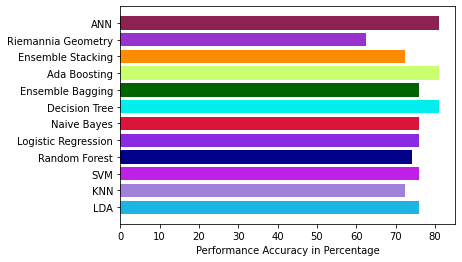

In [46]:
X_bar = ['LDA','KNN','SVM','Random Forest','Logistic Regression','Naive Bayes','Decision Tree','Ensemble Bagging','Ada Boosting','Ensemble Stacking','Riemannia Geometry','ANN']
Y_bar= [lda_acc*100,knn_acc*100, svm_acc*100,rf_acc*100,lr_acc*100,nb_acc*100,dt_acc*100,b_acc*100,ada_acc*100, sc_acc*100,rg_acc*100,ann_acc*100]

import matplotlib.pyplot as plt
plt.barh(X_bar, Y_bar, align='center', color=('#1CB4E3', '#A081DC', '#BE20E7','#00008B','#8A2BE2','#DC143C','#00EEEE','#006400','#CAFF70','#FF8C00','#9932CC','#8B2252'))
plt.xlabel("Performance Accuracy in Percentage")


Text(0.5, 0, 'Performance Cohen Kappa in Percentage')

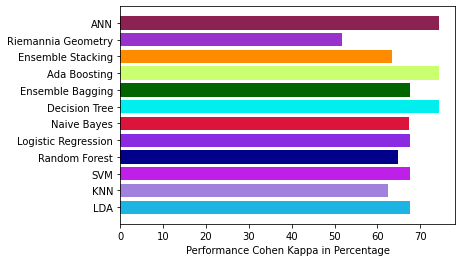

In [47]:
X_bar = ['LDA','KNN','SVM','Random Forest','Logistic Regression','Naive Bayes','Decision Tree','Ensemble Bagging','Ada Boosting','Ensemble Stacking','Riemannia Geometry','ANN']
Y_bar= [lda_ka*100,knn_ka*100, svm_ka*100,rf_ka*100,lr_ka*100,nb_ka*100,dt_ka*100,b_ka*100,ada_ka*100, sc_ka*100,rg_ka*100,ann_ka*100]

import matplotlib.pyplot as plt
plt.barh(X_bar, Y_bar, align='center', color=('#1CB4E3', '#A081DC', '#BE20E7','#00008B','#8A2BE2','#DC143C','#00EEEE','#006400','#CAFF70','#FF8C00','#9932CC','#8B2252'))
plt.xlabel("Performance Cohen Kappa in Percentage")

Text(0.5, 0, 'Performance Precision in Percentage')

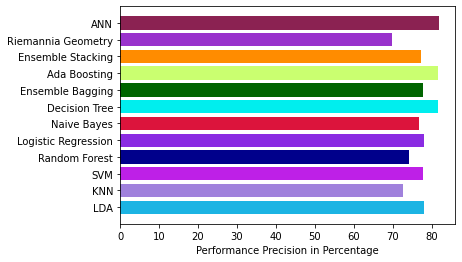

In [48]:
X_bar = ['LDA','KNN','SVM','Random Forest','Logistic Regression','Naive Bayes','Decision Tree','Ensemble Bagging','Ada Boosting','Ensemble Stacking','Riemannia Geometry','ANN']
Y_bar= [lda_prec*100,knn_prec*100, svm_prec*100,rf_prec*100,lr_prec*100,nb_prec*100,dt_prec*100,b_prec*100,ada_prec*100, sc_prec*100,rg_prec*100,ann_prec*100]

import matplotlib.pyplot as plt
plt.barh(X_bar, Y_bar, align='center', color=('#1CB4E3', '#A081DC', '#BE20E7','#00008B','#8A2BE2','#DC143C','#00EEEE','#006400','#CAFF70','#FF8C00','#9932CC','#8B2252'))
plt.xlabel("Performance Precision in Percentage")

Text(0.5, 0, 'Performance Recall in Percentage')

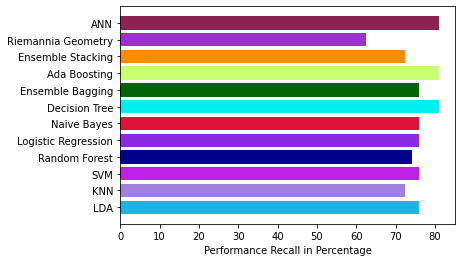

In [49]:
X_bar = ['LDA','KNN','SVM','Random Forest','Logistic Regression','Naive Bayes','Decision Tree','Ensemble Bagging','Ada Boosting','Ensemble Stacking','Riemannia Geometry','ANN']
Y_bar= [lda_rec*100,knn_rec*100, svm_rec*100,rf_rec*100,lr_rec*100,nb_rec*100,dt_rec*100,b_rec*100,ada_rec*100, sc_rec*100,rg_rec*100,ann_rec*100]

import matplotlib.pyplot as plt
plt.barh(X_bar, Y_bar, align='center', color=('#1CB4E3', '#A081DC', '#BE20E7','#00008B','#8A2BE2','#DC143C','#00EEEE','#006400','#CAFF70','#FF8C00','#9932CC','#8B2252'))
plt.xlabel("Performance Recall in Percentage")

Text(0.5, 0, 'Performance f1_score in Percentage')

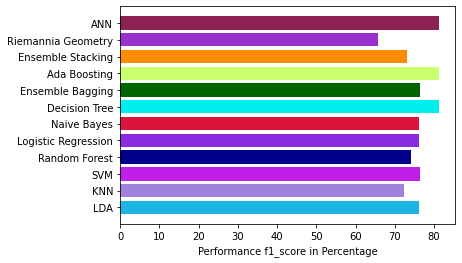

In [50]:
X_bar = ['LDA','KNN','SVM','Random Forest','Logistic Regression','Naive Bayes','Decision Tree','Ensemble Bagging','Ada Boosting','Ensemble Stacking','Riemannia Geometry','ANN']
Y_bar= [lda_f1_score*100,knn_f1_score*100, svm_f1_score*100,rf_f1_score*100,lr_f1_score*100,nb_f1_score*100,dt_f1_score*100,b_f1_score*100,ada_f1_score*100, sc_f1_score*100,rg_f1_score*100,ann_f1_score*100]

import matplotlib.pyplot as plt
plt.barh(X_bar, Y_bar, align='center', color=('#1CB4E3', '#A081DC', '#BE20E7','#00008B','#8A2BE2','#DC143C','#00EEEE','#006400','#CAFF70','#FF8C00','#9932CC','#8B2252'))
plt.xlabel("Performance f1_score in Percentage")

Text(0.5, 0, 'Performance MCC in Percentage')

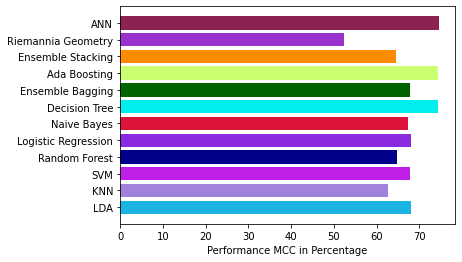

In [51]:
X_bar = ['LDA','KNN','SVM','Random Forest','Logistic Regression','Naive Bayes','Decision Tree','Ensemble Bagging','Ada Boosting','Ensemble Stacking','Riemannia Geometry','ANN']
Y_bar= [lda_mcc*100,knn_mcc*100, svm_mcc*100,rf_mcc*100,lr_mcc*100,nb_mcc*100,dt_mcc*100,b_mcc*100,ada_mcc*100, sc_mcc*100,rg_mcc*100,ann_mcc*100]

import matplotlib.pyplot as plt
plt.barh(X_bar, Y_bar, align='center', color=('#1CB4E3', '#A081DC', '#BE20E7','#00008B','#8A2BE2','#DC143C','#00EEEE','#006400','#CAFF70','#FF8C00','#9932CC','#8B2252'))
plt.xlabel("Performance MCC in Percentage")

Text(0, 0.5, 'Pies Consumed')

<Figure size 160x400 with 0 Axes>

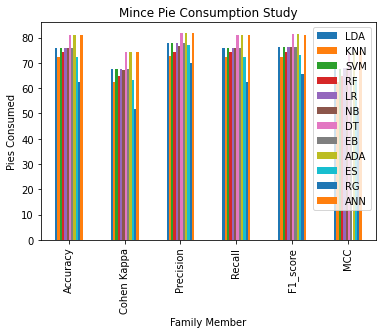

In [58]:
import pandas as pd
from matplotlib.pyplot import figure

plotdata = pd.DataFrame({
    "LDA":[lda_acc*100, lda_ka*100, lda_prec*100, lda_rec*100, lda_f1_score*100, lda_mcc*100],
    "KNN":[knn_acc*100, knn_ka*100, knn_prec*100, knn_rec*100, knn_f1_score*100, knn_mcc*100],
    "SVM":[svm_acc*100, svm_ka*100, svm_prec*100, svm_rec*100, svm_f1_score*100, svm_mcc*100],
    "RF":[rf_acc*100, rf_ka*100, rf_prec*100, rf_rec*100, rf_f1_score*100, rf_mcc*100],
    "LR":[lr_acc*100, lr_ka*100, lr_prec*100, lr_rec*100, lr_f1_score*100, lr_mcc*100],
    "NB":[nb_acc*100, nb_ka*100, nb_prec*100, nb_rec*100, nb_f1_score*100, nb_mcc*100],
    "DT":[dt_acc*100, dt_ka*100, dt_prec*100, dt_rec*100, dt_f1_score*100, dt_mcc*100],
    "EB":[b_acc*100, b_ka*100, b_prec*100, b_rec*100, b_f1_score*100, b_mcc*100],
    "ADA":[ada_acc*100, ada_ka*100, ada_prec*100, ada_rec*100, ada_f1_score*100, ada_mcc*100],
    "ES":[sc_acc*100, sc_ka*100, sc_prec*100, sc_rec*100, sc_f1_score*100, sc_mcc*100],
    "RG":[rg_acc*100, rg_ka*100, rg_prec*100, rg_rec*100, rg_f1_score*100, rg_mcc*100],
    "ANN":[ann_acc*100, ann_ka*100, ann_prec*100, ann_rec*100, ann_f1_score*100, ann_mcc*100]
    }, 
    index=["Accuracy", "Cohen Kappa", "Precision", "Recall", "F1_score", "MCC"]
)
figure(figsize=(2,5), dpi=80)
plotdata.plot(kind="bar")
plt.title("Mince Pie Consumption Study")
plt.xlabel("Family Member")
plt.ylabel("Pies Consumed")





In [72]:
ann_acc*100, ann_ka*100, ann_prec*100, ann_rec*100, ann_f1_score*100, ann_mcc*100

(81.03448275862068,
 74.37751004016064,
 81.94025801784423,
 81.03448275862068,
 81.1314930769909,
 74.58792484692842)